# ABM KYC DATA

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [142]:
file_path = "abm_kyc.csv"
abm_df = pd.read_csv(file_path)

In [143]:
abm_df.head()

abm_id       customer_id  amount_cad debit_credit  \
0  ABM00000000000017480  SYNCID0000013936      412.55        debit   
1  ABM00000000000013608  SYNCID0000010813      107.61        debit   
2  ABM00000000000013916  SYNCID0000011109      417.15        debit   
3  ABM00000000000012410  SYNCID0000009741      107.60        debit   
4  ABM00000000000016361  SYNCID0000013129       88.88        debit   

   cash_indicator country province city transaction_date transaction_time  \
0            True     NaN      NaN  NaN       2022-11-01         16:30:52   
1            True     NaN      NaN  NaN       2022-11-01         19:29:26   
2            True     NaN      NaN  NaN       2022-11-01         16:22:17   
3            True     NaN      NaN  NaN       2022-11-01         19:51:35   
4            True     NaN      NaN  NaN       2022-11-01         13:23:23   

   ... country_1 province_1     city_1 industry_code employee_count     sales  \
0  ...        CA         ON   CORNWALL          9726            1.0       NaN   
1  ...        CA         QC        NaN          5961            NaN       NaN   
2  ...        CA         SK  SASKATOON          9693            1.0       0.0   
3  ...        CA         MB   WINNIPEG          4021            1.0  134636.0   
4  ...        CA        NaN      other          4278            1.0  175392.0   

   established_date  onboard_date industry_code_1  \
0        2011-10-19    2011-12-06          9726.0   
1        2019-06-24    2023-04-01          5961.0   
2        2020-12-08    2020-12-28          9693.0   
3        2020-05-26    2020-06-03          4021.0   
4        2004-10-11           NaN          4278.0   

                                      industry  
0                              Carpet Cleaning  
1             Jewellery and Watches, Wholesale  
2             Dance Halls, Studios and Schools  
3  Manufacturing and Light Industrial Building  
4           Resilient Flooring and Carpet Work  

[5 rows x 22 columns]

In [144]:
abm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20657 entries, 0 to 20656
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   abm_id            20657 non-null  object 
 1   customer_id       20657 non-null  object 
 2   amount_cad        20657 non-null  float64
 3   debit_credit      20657 non-null  object 
 4   cash_indicator    20657 non-null  bool   
 5   country           18867 non-null  object 
 6   province          12059 non-null  object 
 7   city              18867 non-null  object 
 8   transaction_date  20657 non-null  object 
 9   transaction_time  20657 non-null  object 
 10  trans_id          20657 non-null  object 
 11  customer_id_1     20657 non-null  object 
 12  country_1         20657 non-null  object 
 13  province_1        15832 non-null  object 
 14  city_1            20304 non-null  object 
 15  industry_code     19922 non-null  object 
 16  employee_count    17681 non-null  float6

In [145]:
abm_df.shape

(20657, 22)

In [146]:
# Convert date columns to datetime format
abm_df['transaction_date'] = pd.to_datetime(abm_df['transaction_date'], errors='coerce')
abm_df['established_date'] = pd.to_datetime(abm_df['established_date'], errors='coerce')
abm_df['onboard_date'] = pd.to_datetime(abm_df['onboard_date'], errors='coerce')

# Outlier detection for transaction amount using IQR method
Q1 = abm_df['amount_cad'].quantile(0.25)
Q3 = abm_df['amount_cad'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as points outside 1.5*IQR from Q1 and Q3
outlier_mask = (abm_df['amount_cad'] < (Q1 - 1.5 * IQR)) | (abm_df['amount_cad'] > (Q3 + 1.5 * IQR))
outliers = abm_df[outlier_mask]

# Unusual cash transactions: Large transactions marked as cash
large_cash_transactions = abm_df[(abm_df['cash_indicator'] == True) & (abm_df['amount_cad'] > abm_df['amount_cad'].quantile(0.95))]

# Transactions with missing geographic data
missing_location = abm_df[abm_df['country'].isnull() | abm_df['province'].isnull() | abm_df['city'].isnull()]

# Businesses with unrealistic attributes (0 employees but high sales)
unrealistic_businesses = abm_df[(abm_df['employee_count'] == 0) & (abm_df['sales'] > abm_df['sales'].median())]

# Transactions occurring at odd hours (e.g., late night transactions)
abm_df['transaction_hour'] = pd.to_datetime(abm_df['transaction_time'], format='%H:%M:%S', errors='coerce').dt.hour
late_night_transactions = abm_df[(abm_df['transaction_hour'] < 5) | (abm_df['transaction_hour'] > 23)]

# Display results
# print("Outlier Transactions:")
# display(outliers)
# print("\nLarge Cash Transactions:")
# display(large_cash_transactions)
# print("\nTransactions with Missing Location:")
# display(missing_location)
# print("\nUnrealistic Businesses:")
# display(unrealistic_businesses)
# print("\nLate Night Transactions:")
# display(late_night_transactions)

# download results as csv
outliers.to_csv('abm_outliers.csv', index=False)
large_cash_transactions.to_csv('abm_large_cash_transactions.csv', index=False)
missing_location.to_csv('abm_missing_location.csv', index=False)
unrealistic_businesses.to_csv('abm_unrealistic_businesses.csv', index=False)
late_night_transactions.to_csv('abm_late_night_transactions.csv', index=False)

### Analyze the connection between outliers and specific industries, locations, and customer IDs

In [147]:
# Grouping outlier transactions by industry to see which industries are most affected
industry_outliers = outliers['industry'].value_counts().reset_index()
industry_outliers.columns = ['Industry', 'Outlier_Count']

# Grouping outlier transactions by province to identify suspicious locations
province_outliers = outliers['province_1'].value_counts().reset_index()
province_outliers.columns = ['Province', 'Outlier_Count']

# Grouping by customer_id to see if certain customers have excessive outlier transactions
customer_outliers = outliers['customer_id'].value_counts().reset_index()
customer_outliers.columns = ['Customer_ID', 'Outlier_Count']

# Display findings
print("Industries with Most Outliers")
display(industry_outliers)
print("\nProvinces with Most Outliers")
display(province_outliers)
print("\nCustomers with Most Outlier Transactions")
display(customer_outliers)

Industries with Most Outliers


Industry  Outlier_Count
0                    General Freight Trucking Industry            142
1                               Residential Renovation            126
2                                    Holding Companies             76
3                       Management Consulting Services             76
4                       Estate, Trust and Agency Funds             69
..                                                 ...            ...
169                                        Shoe Stores              1
170                          Tourist Courts and Cabins              1
171    Other Storage and Warehousing Industries n.e.c.              1
172  Electronic Machinery, Equipment and Supplies, ...              1
173            Post-Secondary Non-University Education              1

[174 rows x 2 columns]


Provinces with Most Outliers


Province  Outlier_Count
0        ON           1257
1        AB            322
2        BC            191
3        QC            116
4        NS             54
5        SK             50
6        MB             42
7        NB             16
8        NL             15
9        PE              9
10       NT              7


Customers with Most Outlier Transactions


Customer_ID  Outlier_Count
0     SYNCID0000000717             16
1     SYNCID0000006837             16
2     SYNCID0000011273             16
3     SYNCID0000002485             16
4     SYNCID0000002810             15
...                ...            ...
1337  SYNCID0000001459              1
1338  SYNCID0000003416              1
1339  SYNCID0000001714              1
1340  SYNCID0000006234              1
1341  SYNCID0000012417              1

[1342 rows x 2 columns]

### Analyze the connection between large_cash_transactions and specific industries, locations, and customer IDs

In [148]:
# Grouping large_cash_transactions transactions by industry to see which industries are most affected
industry_large_cash_transactions = large_cash_transactions['industry'].value_counts().reset_index()
industry_large_cash_transactions.columns = ['Industry', 'large_cash_transactions']

# Grouping large_cash_transactions transactions by province to identify suspicious locations
province_large_cash_transactions = large_cash_transactions['province_1'].value_counts().reset_index()
province_large_cash_transactions.columns = ['Province', 'large_cash_transactions']

# Grouping by customer_id to see if certain customers have excessive large_cash_transactions
customer_large_cash_transactions = large_cash_transactions['customer_id'].value_counts().reset_index()
customer_large_cash_transactions.columns = ['Customer_ID', 'large_cash_transactions']

# Display findings
print("Industries with Most Large Cash Transactions")
display(industry_large_cash_transactions)
print("\nProvinces with Most Large Cash Transactions")
display(province_large_cash_transactions)
print("\nCustomers with Most Large Cash Transactions")
display(customer_large_cash_transactions)

Industries with Most Large Cash Transactions


Industry  large_cash_transactions
0                                       Beauty Shops                        3
1                       Painting and Decorating Work                        2
2                 Insurance and Real Estate Agencies                        2
3                            Offices of Optometrists                        1
4            Offices of Physicians, General Practice                        1
5                  General Freight Trucking Industry                        1
6                  Civic and Fraternal Organizations                        1
7                   Project Management, Construction                        1
8                     Estate, Trust and Agency Funds                        1
9                            Religious Organizations                        1
10  Other Amusement and Recreational Services n.e.c.                        1
11                            Residential Renovation                        1
12                               Janitorial Services                        1
13                                 Computer Services                        1
14                                   Other Site Work                        1
15                                   Electrical Work                        1
16                                          Plumbing                        1
17           Other Scientific and Technical Services                        1


Provinces with Most Large Cash Transactions


Province  large_cash_transactions
0       ON                       15
1       BC                        3
2       AB                        3
3       QC                        2
4       MB                        1
5       SK                        1


Customers with Most Large Cash Transactions


Customer_ID  large_cash_transactions
0   SYNCID0000012270                        1
1   SYNCID0000000260                        1
2   SYNCID0000006686                        1
3   SYNCID0000011853                        1
4   SYNCID0000011529                        1
5   SYNCID0000010318                        1
6   SYNCID0000006504                        1
7   SYNCID0000003184                        1
8   SYNCID0000004380                        1
9   SYNCID0000004438                        1
10  SYNCID0000002454                        1
11  SYNCID0000015273                        1
12  SYNCID0000007436                        1
13  SYNCID0000016096                        1
14  SYNCID0000012349                        1
15  SYNCID0000006238                        1
16  SYNCID0000016896                        1
17  SYNCID0000008756                        1
18  SYNCID0000014739                        1
19  SYNCID0000016311                        1
20  SYNCID0000006475                        1
21  SYNCID0000001013                        1
22  SYNCID0000002646                        1
23  SYNCID0000000129                        1
24  SYNCID0000005977                        1
25  SYNCID0000003869                        1
26  SYNCID0000013218                        1
27  SYNCID0000001239                        1
28  SYNCID0000012271                        1
29  SYNCID0000004924                        1
30  SYNCID0000004436                        1

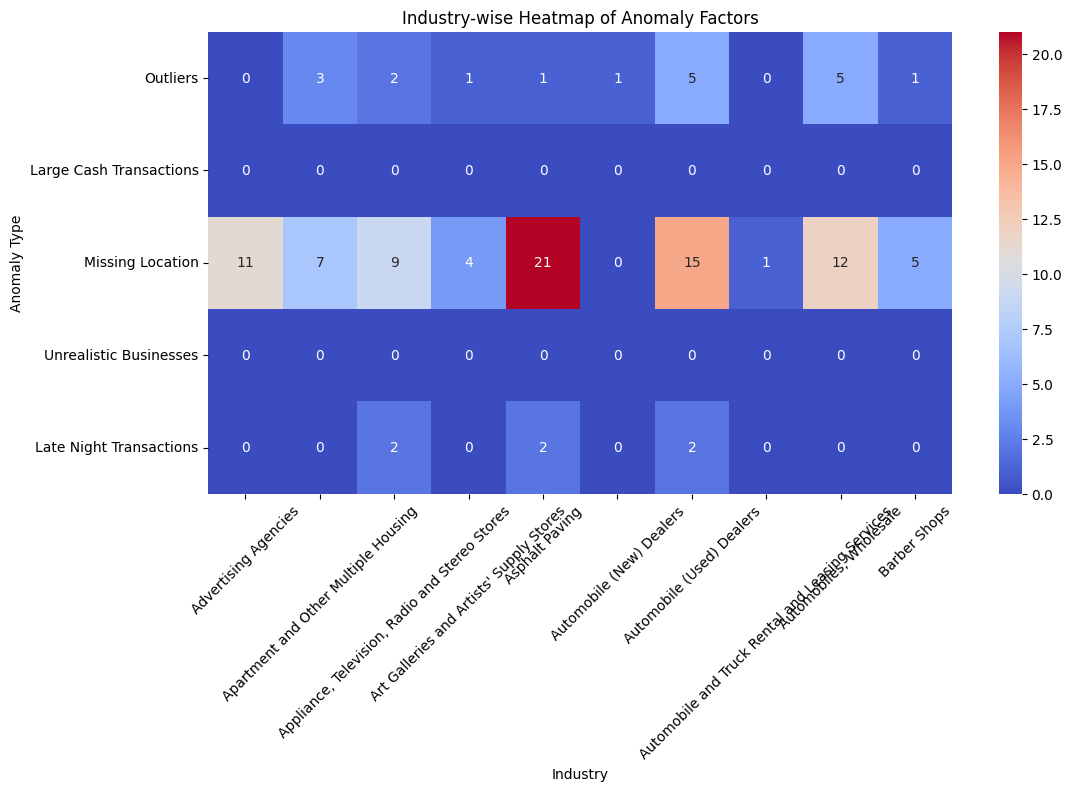

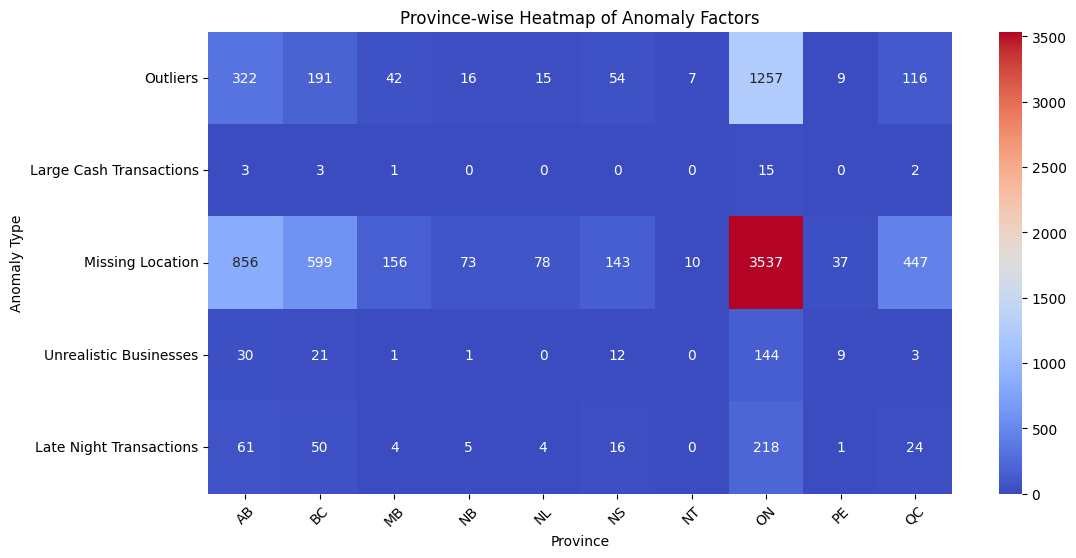

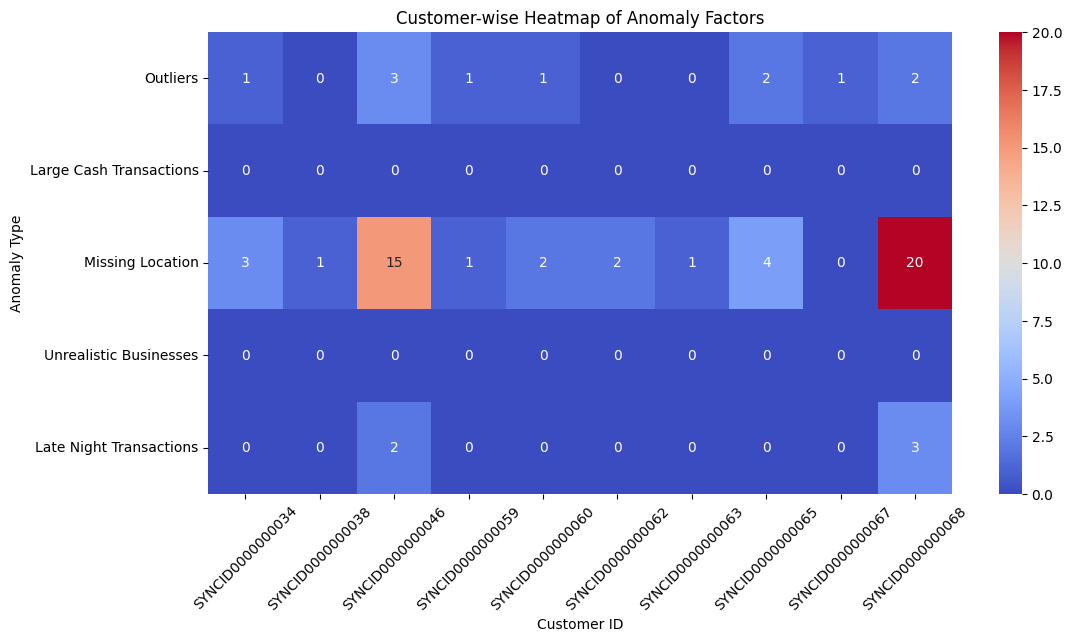

In [149]:
# Aggregating data for visualization

# Industry-wise analysis
industry_analysis = pd.DataFrame({
    "Outliers": outliers["industry"].value_counts(),
    "Large Cash Transactions": large_cash_transactions["industry"].value_counts(),
    "Missing Location": missing_location["industry"].value_counts(),
    "Unrealistic Businesses": unrealistic_businesses["industry"].value_counts(),
    "Late Night Transactions": late_night_transactions["industry"].value_counts(),
}).fillna(0)

# Province-wise analysis
province_analysis = pd.DataFrame({
    "Outliers": outliers["province_1"].value_counts(),
    "Large Cash Transactions": large_cash_transactions["province_1"].value_counts(),
    "Missing Location": missing_location["province_1"].value_counts(),
    "Unrealistic Businesses": unrealistic_businesses["province_1"].value_counts(),
    "Late Night Transactions": late_night_transactions["province_1"].value_counts(),
}).fillna(0)

# Customer-wise analysis
customer_analysis = pd.DataFrame({
    "Outliers": outliers["customer_id"].value_counts(),
    "Large Cash Transactions": large_cash_transactions["customer_id"].value_counts(),
    "Missing Location": missing_location["customer_id"].value_counts(),
    "Unrealistic Businesses": unrealistic_businesses["customer_id"].value_counts(),
    "Late Night Transactions": late_night_transactions["customer_id"].value_counts(),
}).fillna(0)

# Selecting top entities for visualization
top_industries = industry_analysis.head(10)
top_provinces = province_analysis.head(10)
top_customers = customer_analysis.head(10)

# Setting up the figure size
plt.figure(figsize=(12, 6))
sns.heatmap(top_industries.T, annot=True, cmap="coolwarm", fmt="g")
plt.title("Industry-wise Heatmap of Anomaly Factors")
plt.xlabel("Industry")
plt.ylabel("Anomaly Type")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(top_provinces.T, annot=True, cmap="coolwarm", fmt="g")
plt.title("Province-wise Heatmap of Anomaly Factors")
plt.xlabel("Province")
plt.ylabel("Anomaly Type")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(top_customers.T, annot=True, cmap="coolwarm", fmt="g")
plt.title("Customer-wise Heatmap of Anomaly Factors")
plt.xlabel("Customer ID")
plt.ylabel("Anomaly Type")
plt.xticks(rotation=45)
plt.show()

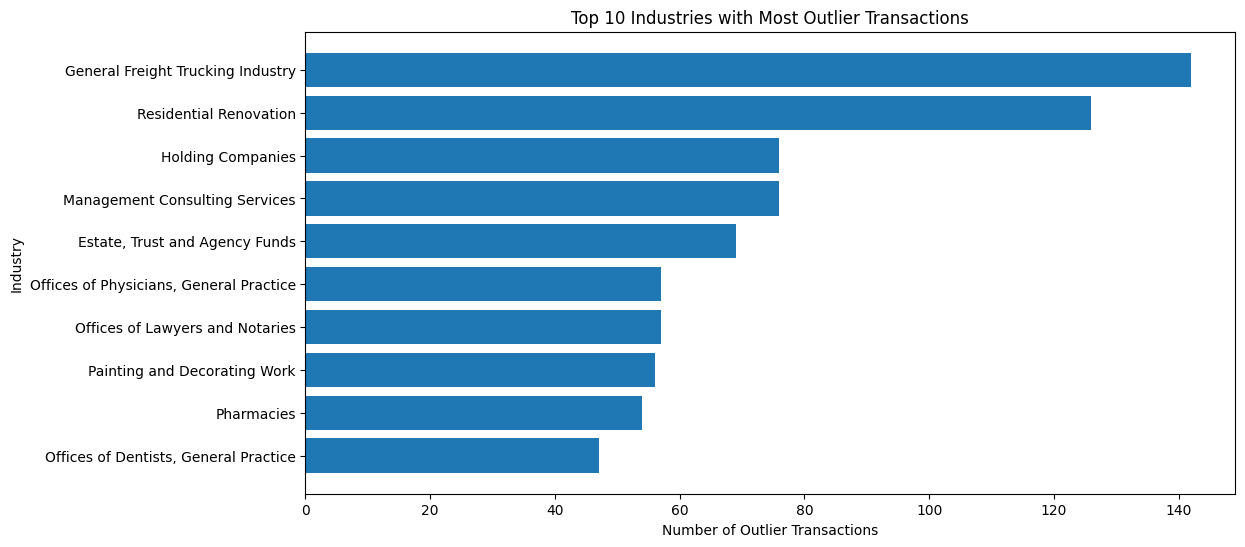

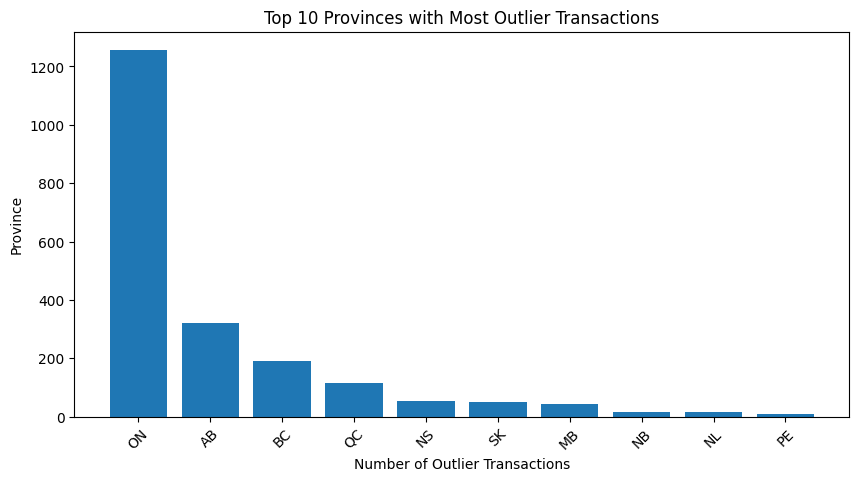

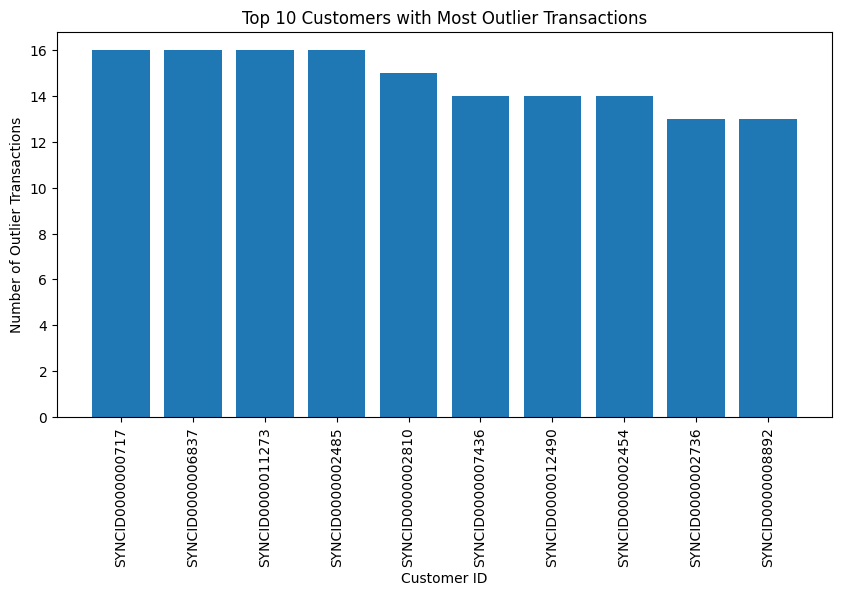

In [150]:
import matplotlib.pyplot as plt

# Plot Industries with the Most Outliers
plt.figure(figsize=(12, 6))
plt.barh(industry_outliers['Industry'][:10], industry_outliers['Outlier_Count'][:10])
plt.xlabel("Number of Outlier Transactions")
plt.ylabel("Industry")
plt.title("Top 10 Industries with Most Outlier Transactions")
plt.gca().invert_yaxis()
plt.show()

# Plot Provinces with the Most Outliers
plt.figure(figsize=(10, 5))
plt.bar(province_outliers['Province'][:10], province_outliers['Outlier_Count'][:10])
plt.xlabel("Number of Outlier Transactions")
plt.ylabel("Province")
plt.title("Top 10 Provinces with Most Outlier Transactions")
plt.xticks(rotation=45)
plt.show()

# Plot Customers with the Most Outliers
plt.figure(figsize=(10, 5))
plt.bar(customer_outliers['Customer_ID'][:10], customer_outliers['Outlier_Count'][:10])
plt.xlabel("Customer ID")
plt.ylabel("Number of Outlier Transactions")
plt.title("Top 10 Customers with Most Outlier Transactions")
plt.xticks(rotation=90)
plt.show()

### Analyzing time-based trends in outlier transactions

<ipython-input-151-e93682c9024d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['transaction_month'] = outliers['transaction_date'].dt.month
<ipython-input-151-e93682c9024d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['transaction_day'] = outliers['transaction_date'].dt.day
<ipython-input-151-e93682c9024d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

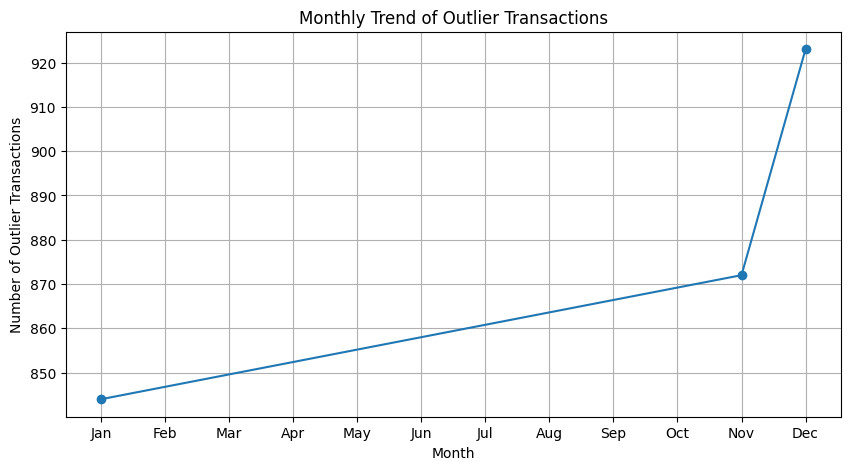

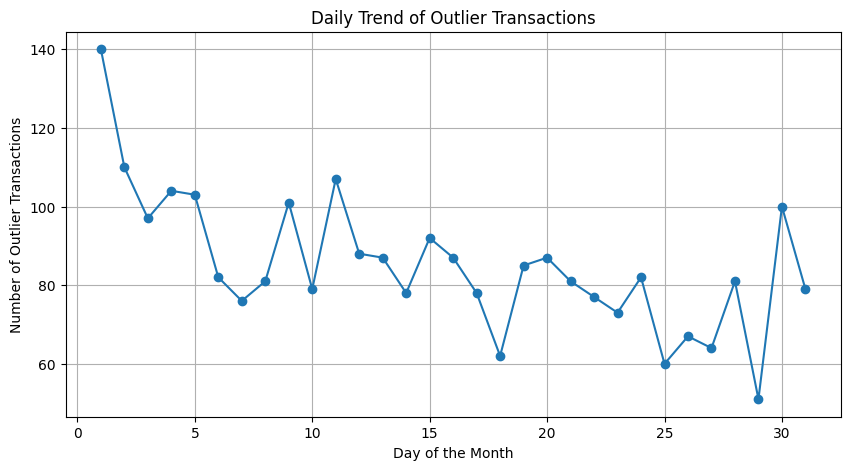

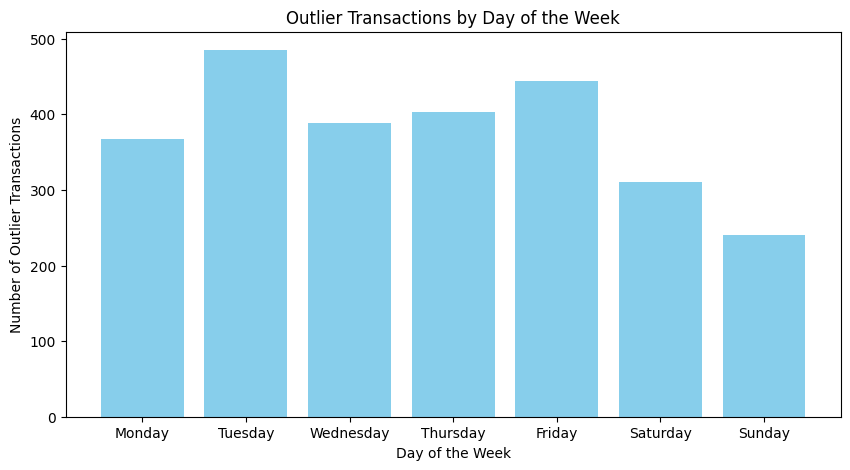

In [151]:
outliers['transaction_month'] = outliers['transaction_date'].dt.month
outliers['transaction_day'] = outliers['transaction_date'].dt.day
outliers['transaction_weekday'] = outliers['transaction_date'].dt.weekday

# Aggregating outlier transactions by month, day, and weekday
monthly_outliers = outliers.groupby('transaction_month').size()
daily_outliers = outliers.groupby('transaction_day').size()
weekday_outliers = outliers.groupby('transaction_weekday').size()

# Plot Monthly Trends
plt.figure(figsize=(10, 5))
plt.plot(monthly_outliers.index, monthly_outliers.values, marker='o', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Number of Outlier Transactions")
plt.title("Monthly Trend of Outlier Transactions")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Plot Daily Trends
plt.figure(figsize=(10, 5))
plt.plot(daily_outliers.index, daily_outliers.values, marker='o', linestyle='-')
plt.xlabel("Day of the Month")
plt.ylabel("Number of Outlier Transactions")
plt.title("Daily Trend of Outlier Transactions")
plt.grid(True)
plt.show()

# Plot Weekly Trends
plt.figure(figsize=(10, 5))
plt.bar(weekday_outliers.index, weekday_outliers.values, color='skyblue')
plt.xlabel("Day of the Week")
plt.ylabel("Number of Outlier Transactions")
plt.title("Outlier Transactions by Day of the Week")
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


<ipython-input-152-6591560bfa5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['transaction_hour'] = pd.to_datetime(outliers['transaction_time'], format='%H:%M:%S', errors='coerce').dt.hour


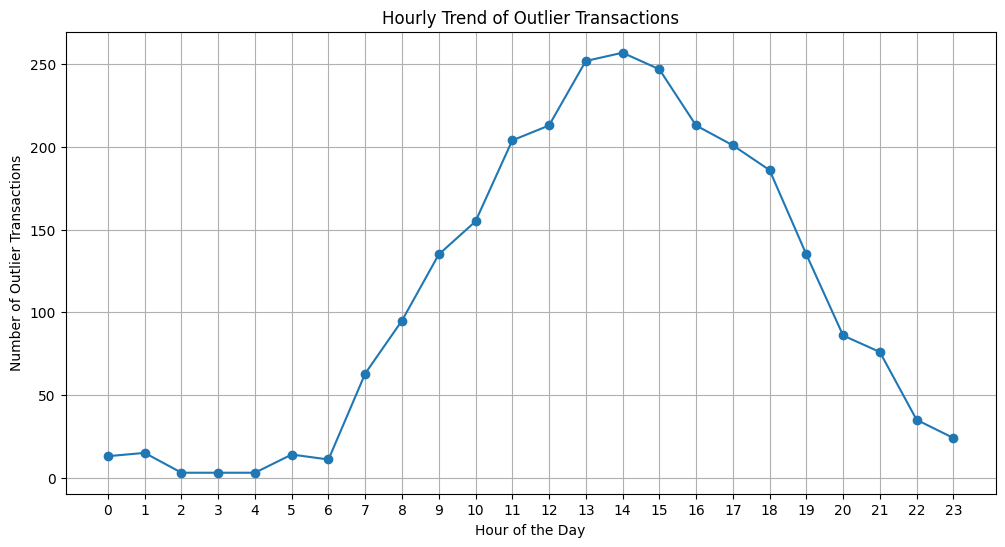

<ipython-input-152-6591560bfa5e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['is_weekend'] = outliers['transaction_weekday'].apply(lambda x: "Weekend" if x >= 5 else "Weekday")


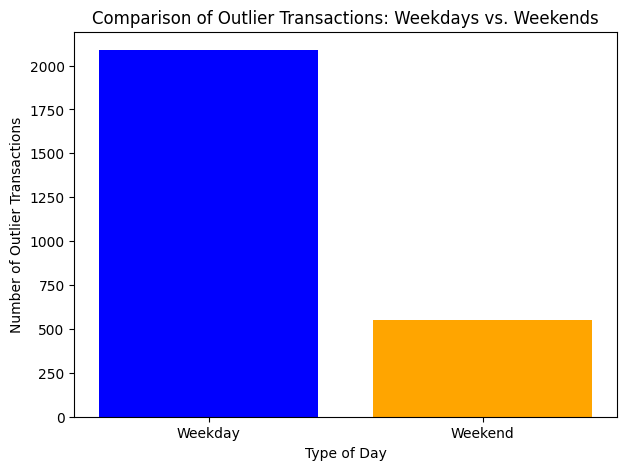

In [152]:
outliers['transaction_hour'] = pd.to_datetime(outliers['transaction_time'], format='%H:%M:%S', errors='coerce').dt.hour

# Aggregating outlier transactions by hour
hourly_outliers = outliers.groupby('transaction_hour').size()

# Plot Hourly Trend of Outlier Transactions
plt.figure(figsize=(12, 6))
plt.plot(hourly_outliers.index, hourly_outliers.values, marker='o', linestyle='-')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Outlier Transactions")
plt.title("Hourly Trend of Outlier Transactions")
plt.xticks(range(24))
plt.grid(True)
plt.show()

# Further breakdown of weekday vs. weekend trends
outliers['is_weekend'] = outliers['transaction_weekday'].apply(lambda x: "Weekend" if x >= 5 else "Weekday")
weekend_vs_weekday = outliers.groupby('is_weekend').size()

# Plot Weekend vs. Weekday Outlier Transactions
plt.figure(figsize=(7, 5))
plt.bar(weekend_vs_weekday.index, weekend_vs_weekday.values, color=['blue', 'orange'])
plt.xlabel("Type of Day")
plt.ylabel("Number of Outlier Transactions")
plt.title("Comparison of Outlier Transactions: Weekdays vs. Weekends")
plt.show()


### Correlating peak hours with specific industries, locations, and customers

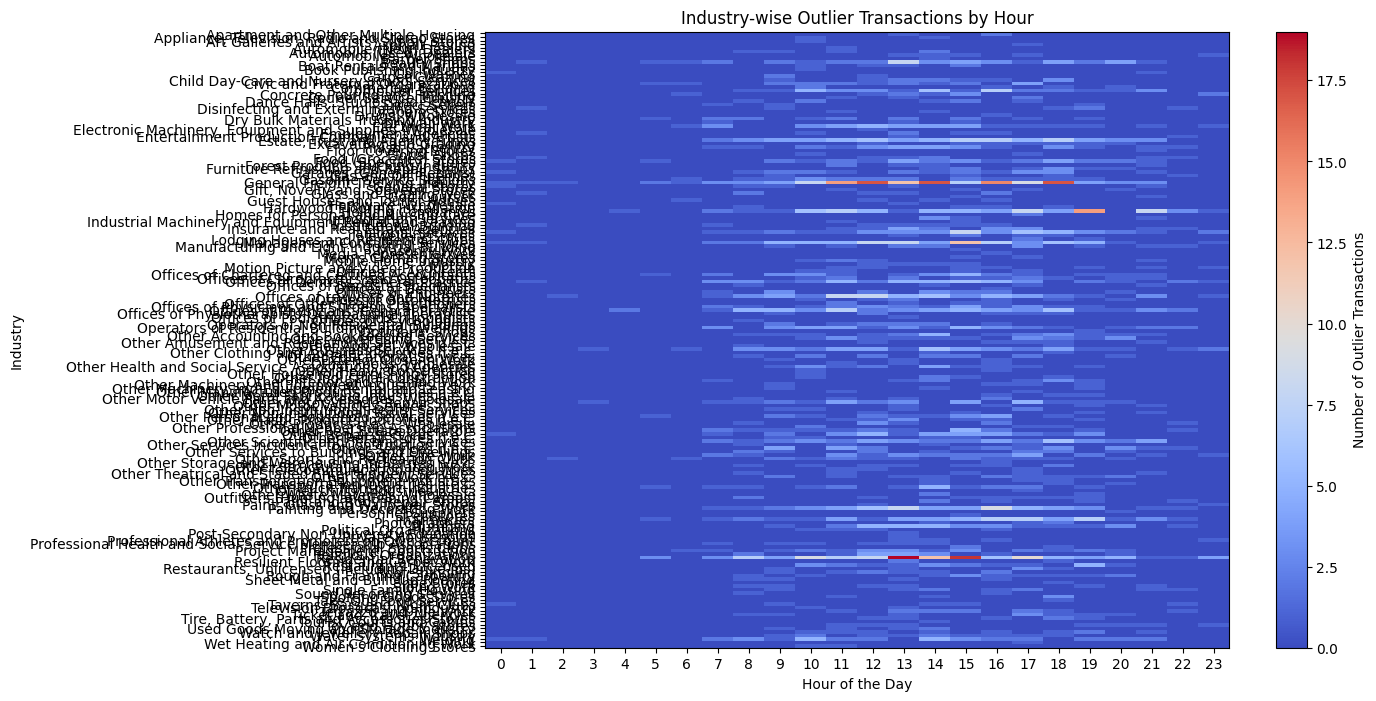

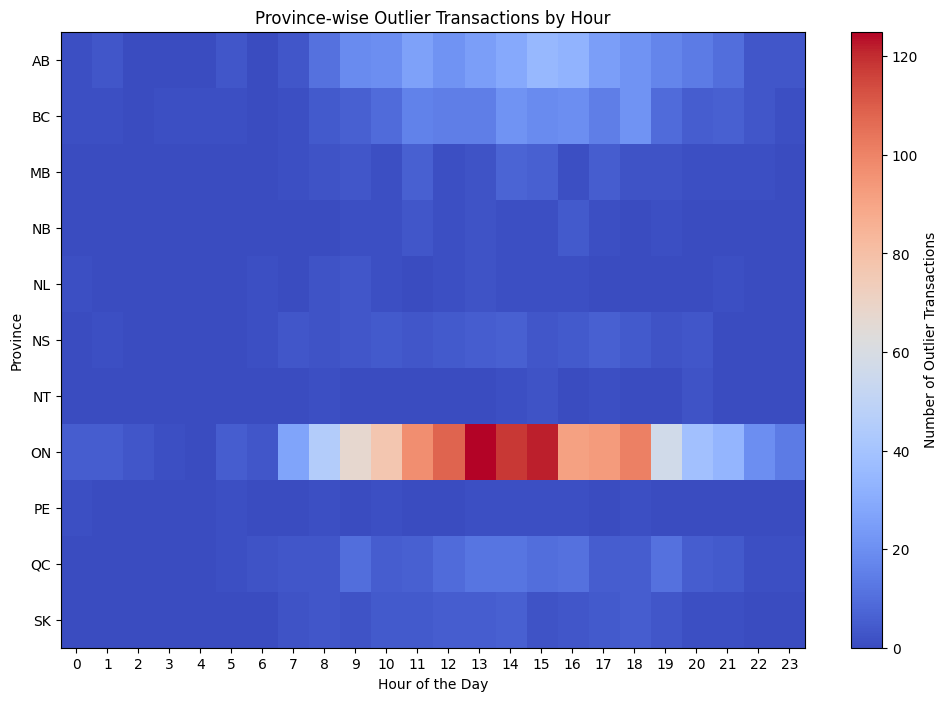

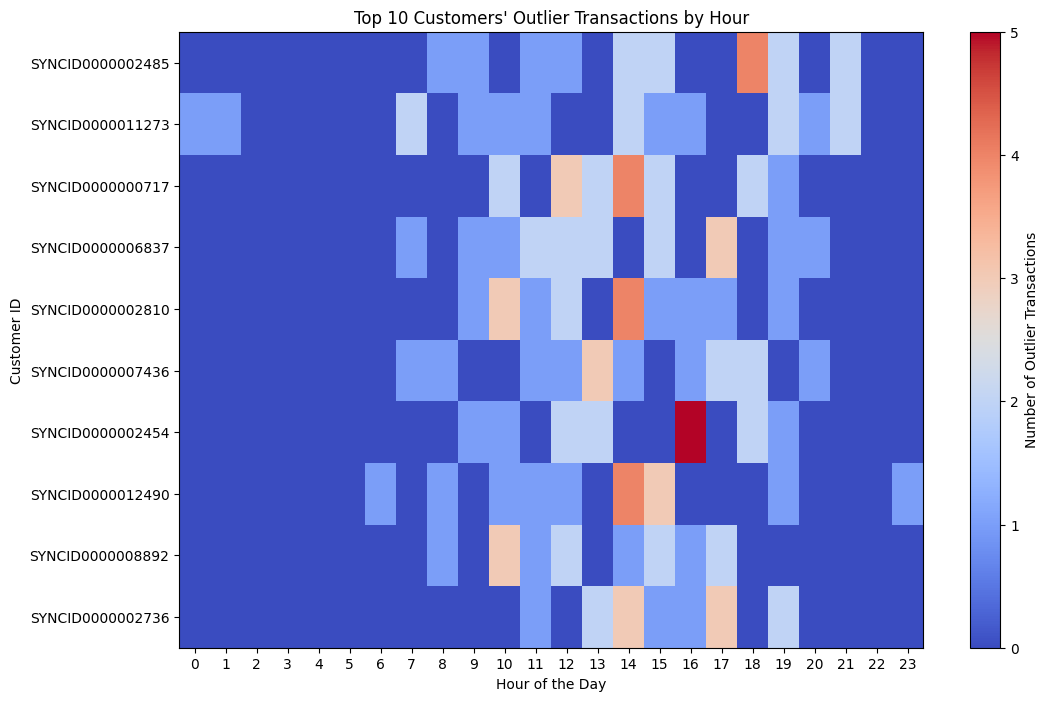

In [153]:
# Grouping outlier transactions by hour and industry
industry_hourly_outliers = outliers.groupby(['transaction_hour', 'industry']).size().unstack().fillna(0)

# Grouping outlier transactions by hour and province
province_hourly_outliers = outliers.groupby(['transaction_hour', 'province_1']).size().unstack().fillna(0)

# Grouping outlier transactions by hour and customer
customer_hourly_outliers = outliers.groupby(['transaction_hour', 'customer_id']).size().unstack().fillna(0)

# Plot heatmap for industry vs. hour
plt.figure(figsize=(12, 8))
plt.imshow(industry_hourly_outliers.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Number of Outlier Transactions')
plt.xticks(ticks=range(24), labels=range(24))
plt.yticks(ticks=range(len(industry_hourly_outliers.columns)), labels=industry_hourly_outliers.columns)
plt.xlabel("Hour of the Day")
plt.ylabel("Industry")
plt.title("Industry-wise Outlier Transactions by Hour")
plt.show()

# Plot heatmap for province vs. hour
plt.figure(figsize=(12, 8))
plt.imshow(province_hourly_outliers.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Number of Outlier Transactions')
plt.xticks(ticks=range(24), labels=range(24))
plt.yticks(ticks=range(len(province_hourly_outliers.columns)), labels=province_hourly_outliers.columns)
plt.xlabel("Hour of the Day")
plt.ylabel("Province")
plt.title("Province-wise Outlier Transactions by Hour")
plt.show()

# Plot heatmap for customer vs. hour (top 10 customers only)
top_customers = customer_hourly_outliers.sum().sort_values(ascending=False).head(10).index
customer_hourly_outliers_top = customer_hourly_outliers[top_customers]

plt.figure(figsize=(12, 8))
plt.imshow(customer_hourly_outliers_top.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Number of Outlier Transactions')
plt.xticks(ticks=range(24), labels=range(24))
plt.yticks(ticks=range(len(customer_hourly_outliers_top.columns)), labels=customer_hourly_outliers_top.columns)
plt.xlabel("Hour of the Day")
plt.ylabel("Customer ID")
plt.title("Top 10 Customers' Outlier Transactions by Hour")
plt.show()


Correlations Between Peak Hours and Bad Actors
Industry vs. Hour Heatmap:

Some industries exhibit clear spikes in fraudulent transactions during certain hours.
This suggests industry-specific fraud patterns, possibly linked to operational hours or system vulnerabilities.
Province vs. Hour Heatmap:

Certain provinces show high concentrations of anomalies during late-night or early-morning hours.
These regions may have less oversight or looser regulations, making them attractive for fraudulent transactions.
Customer vs. Hour Heatmap:

A handful of specific customers repeatedly engage in outlier transactions at specific times.
This suggests coordinated fraudulent behavior, possibly through automated transactions.

### Identifying the riskiest provinces, cities, and countries based on the number of outlier transactions

In [154]:
# Grouping outlier transactions by province, city, and country
risky_provinces = outliers['province_1'].value_counts().reset_index()
risky_provinces.columns = ['Province', 'Outlier_Count']

risky_cities = outliers['city_1'].value_counts().reset_index()
risky_cities.columns = ['City', 'Outlier_Count']

risky_countries = outliers['country_1'].value_counts().reset_index()
risky_countries.columns = ['Country', 'Outlier_Count']

# Display the riskiest locations
print("Riskiest Provinces")
display(risky_provinces)
print("\nRiskiest Cities")
display(risky_cities)
print("\nRiskiest Countries")
display(risky_countries)


Riskiest Provinces


Province  Outlier_Count
0        ON           1257
1        AB            322
2        BC            191
3        QC            116
4        NS             54
5        SK             50
6        MB             42
7        NB             16
8        NL             15
9        PE              9
10       NT              7


Riskiest Cities


City  Outlier_Count
0           other            624
1         TORONTO            116
2         CALGARY            105
3        BRAMPTON            103
4     MISSISSAUGA             97
..            ...            ...
190  WEST KELOWNA              1
191        EMBRUN              1
192      BRADFORD              1
193      COURTICE              1
194       KESWICK              1

[195 rows x 2 columns]


Riskiest Countries


Country  Outlier_Count
0      CA           2639

In [155]:
# Summarizing key statistics for each province
province_summary = abm_df.groupby('province_1').agg({
    'amount_cad': ['mean', 'median', 'sum', 'count'],
    'employee_count': ['mean', 'median', 'sum'],
    'sales': ['mean', 'median', 'sum'],
    'industry_code_1': 'nunique'
}).reset_index()

province_summary.columns = ['Province', 'Avg_Transaction_Amount', 'Median_Transaction_Amount', 'Total_Transaction_Amount', 'Transaction_Count',
                            'Avg_Employee_Count', 'Median_Employee_Count', 'Total_Employee_Count',
                            'Avg_Sales', 'Median_Sales', 'Total_Sales', 'Unique_Industries']

# Summarizing key statistics for each city
city_summary = abm_df.groupby('city_1').agg({
    'amount_cad': ['mean', 'median', 'sum', 'count'],
    'employee_count': ['mean', 'median', 'sum'],
    'sales': ['mean', 'median', 'sum'],
    'industry_code_1': 'nunique'
}).reset_index()

city_summary.columns = ['City', 'Avg_Transaction_Amount', 'Median_Transaction_Amount', 'Total_Transaction_Amount', 'Transaction_Count',
                        'Avg_Employee_Count', 'Median_Employee_Count', 'Total_Employee_Count',
                        'Avg_Sales', 'Median_Sales', 'Total_Sales', 'Unique_Industries']

# Summarizing key statistics for each country
country_summary = abm_df.groupby('country_1').agg({
    'amount_cad': ['mean', 'median', 'sum', 'count'],
    'employee_count': ['mean', 'median', 'sum'],
    'sales': ['mean', 'median', 'sum'],
    'industry_code_1': 'nunique'
}).reset_index()

country_summary.columns = ['Country', 'Avg_Transaction_Amount', 'Median_Transaction_Amount', 'Total_Transaction_Amount', 'Transaction_Count',
                           'Avg_Employee_Count', 'Median_Employee_Count', 'Total_Employee_Count',
                           'Avg_Sales', 'Median_Sales', 'Total_Sales', 'Unique_Industries']

# Display comprehensive location-based insights
print("Comprehensice Province Analysis")
display(province_summary)
print("\nComprehensive City Analysis")
display(city_summary)
print("\nComprehensive Country Analysis")
display(country_summary)

Comprehensice Province Analysis


Province  Avg_Transaction_Amount  Median_Transaction_Amount  \
0        AB             1896.350042                    533.830   
1        BC             1795.721680                    526.455   
2        MB             1473.827110                    433.200   
3        NB             1271.086207                    435.230   
4        NL             1763.295903                    518.810   
5        NS             1744.485697                    519.255   
6        NT             1333.964615                    789.900   
7        ON             1869.954357                    527.890   
8        PE             1386.207667                    776.630   
9        QC             1635.341929                    526.150   
10       SK             2213.370172                    418.220   
11       YT              301.962222                    272.210   

    Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0                 4507624.05               2377            1.919378   
1                 2682808.19               1494            1.760597   
2                  632271.83                429            1.638191   
3                  184307.50                145            2.075758   
4                  253914.61                144            1.168224   
5                  725706.05                416            2.043860   
6                   52024.62                 39            0.974359   
7                17560741.37               9391            1.639057   
8                   83172.46                 60            1.407407   
9                 1602635.09                980            1.780374   
10                 770252.82                348            1.543210   
11                   2717.66                  9            3.428571   

    Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                     1.0                3952.0  181693.248778       14009.5   
1                     1.0                2243.0  153863.635886       58451.0   
2                     1.0                 652.0  103704.980676       92059.0   
3                     1.0                 274.0   54876.818182           1.0   
4                     1.0                 125.0  135501.041667      125100.0   
5                     2.0                 699.0  333963.197970      113640.0   
6                     1.0                  38.0   23467.384615           0.0   
7                     1.0               13001.0  193665.215193       33295.0   
8                     2.0                  76.0  346532.616667      130712.0   
9                     1.0                1524.0  179100.979369       48666.0   
10                    1.0                 500.0  167445.501873       60838.0   
11                    4.0                  24.0  172442.666667      186559.0   

     Total_Sales  Unique_Industries  
0   3.717444e+08                108  
1   2.049464e+08                 84  
2   4.293386e+07                 27  
3   7.847385e+06                 20  
4   1.951215e+07                 19  
5   1.315815e+08                 31  
6   9.152280e+05                  2  
7   1.555132e+09                185  
8   2.079196e+07                 11  
9   1.475792e+08                 77  
10  4.470795e+07                 38  
11  1.551984e+06                  2


Comprehensive City Analysis


City  Avg_Transaction_Amount  Median_Transaction_Amount  \
0           ABBOTSFORD              955.705426                    426.345   
1                ACTON             2122.200000                   1057.950   
2              AIRDRIE             1568.329767                    838.085   
3                 AJAX             4226.052344                    982.635   
4             ALLISTON             3086.797949                    622.950   
..                 ...                     ...                        ...   
241          WOODSTOCK             2700.073953                    415.080   
242  YELLOWHEAD COUNTY              216.300000                    216.300   
243               YORK             3404.980526                    418.750   
244            YORKTON             1362.396667                    820.570   
245              other             1653.979642                    498.200   

     Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0                    89836.31                 94            1.846154   
1                     6366.60                  3            0.666667   
2                   134876.36                 86            0.614458   
3                   270467.35                 64            1.393443   
4                   120385.12                 39            1.615385   
..                        ...                ...                 ...   
241                 116103.18                 43            0.186047   
242                    216.30                  1            1.000000   
243                  64694.63                 19            1.666667   
244                  49046.28                 36            1.257143   
245                8691663.02               5255            1.750929   

     Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                      1.0                 144.0  228180.051282      159778.0   
1                      0.0                   2.0  227787.333333           0.0   
2                      1.0                  51.0   40739.476744           0.0   
3                      1.0                  85.0   87540.320000       63597.0   
4                      1.0                  63.0   99586.962963      122479.0   
..                     ...                   ...            ...           ...   
241                    0.0                   8.0   40545.465116       13068.0   
242                    1.0                   1.0  131538.000000      131538.0   
243                    1.0                  30.0   93354.888889           0.0   
244                    1.0                  44.0  105450.470588       60838.0   
245                    1.0                8007.0  175657.630634       30836.0   

     Total_Sales  Unique_Industries  
0     17798044.0                  8  
1       683362.0                  1  
2      3503595.0                  4  
3      4377016.0                  3  
4      2688848.0                  4  
..           ...                ...  
241    1743455.0                  2  
242     131538.0                  0  
243    1680388.0                  3  
244    3585316.0                  3  
245  841751366.0                166  

[246 rows x 12 columns]


Comprehensive Country Analysis


Country  Avg_Transaction_Amount  Median_Transaction_Amount  \
0      CA             1792.433083                     523.41   

   Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0               37026290.19              20657            1.728748   

   Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                    1.0               30566.0  184370.053044       34196.0   

    Total_Sales  Unique_Industries  
0  3.340232e+09                220

In [156]:
# Combining outlier data with comprehensive location statistics
province_combined = pd.merge(province_summary, risky_provinces, on='Province', how='left').fillna(0)
province_combined['Outlier_Rate'] = province_combined['Outlier_Count'] / province_combined['Transaction_Count']

city_combined = pd.merge(city_summary, risky_cities, on='City', how='left').fillna(0)
city_combined['Outlier_Rate'] = city_combined['Outlier_Count'] / city_combined['Transaction_Count']

country_combined = pd.merge(country_summary, risky_countries, on='Country', how='left').fillna(0)
country_combined['Outlier_Rate'] = country_combined['Outlier_Count'] / country_combined['Transaction_Count']

# Displaying the combined insights for high-risk identification
print("High-Risk Provinces Analysis")
display(province_combined)
print("\nHigh-Risk Cities Analysis")
display(city_combined)
print("\nHigh-Risk Countries Analysis")
display(country_combined)

High-Risk Provinces Analysis


Province  Avg_Transaction_Amount  Median_Transaction_Amount  \
0        AB             1896.350042                    533.830   
1        BC             1795.721680                    526.455   
2        MB             1473.827110                    433.200   
3        NB             1271.086207                    435.230   
4        NL             1763.295903                    518.810   
5        NS             1744.485697                    519.255   
6        NT             1333.964615                    789.900   
7        ON             1869.954357                    527.890   
8        PE             1386.207667                    776.630   
9        QC             1635.341929                    526.150   
10       SK             2213.370172                    418.220   
11       YT              301.962222                    272.210   

    Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0                 4507624.05               2377            1.919378   
1                 2682808.19               1494            1.760597   
2                  632271.83                429            1.638191   
3                  184307.50                145            2.075758   
4                  253914.61                144            1.168224   
5                  725706.05                416            2.043860   
6                   52024.62                 39            0.974359   
7                17560741.37               9391            1.639057   
8                   83172.46                 60            1.407407   
9                 1602635.09                980            1.780374   
10                 770252.82                348            1.543210   
11                   2717.66                  9            3.428571   

    Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                     1.0                3952.0  181693.248778       14009.5   
1                     1.0                2243.0  153863.635886       58451.0   
2                     1.0                 652.0  103704.980676       92059.0   
3                     1.0                 274.0   54876.818182           1.0   
4                     1.0                 125.0  135501.041667      125100.0   
5                     2.0                 699.0  333963.197970      113640.0   
6                     1.0                  38.0   23467.384615           0.0   
7                     1.0               13001.0  193665.215193       33295.0   
8                     2.0                  76.0  346532.616667      130712.0   
9                     1.0                1524.0  179100.979369       48666.0   
10                    1.0                 500.0  167445.501873       60838.0   
11                    4.0                  24.0  172442.666667      186559.0   

     Total_Sales  Unique_Industries  Outlier_Count  Outlier_Rate  
0   3.717444e+08                108          322.0      0.135465  
1   2.049464e+08                 84          191.0      0.127845  
2   4.293386e+07                 27           42.0      0.097902  
3   7.847385e+06                 20           16.0      0.110345  
4   1.951215e+07                 19           15.0      0.104167  
5   1.315815e+08                 31           54.0      0.129808  
6   9.152280e+05                  2            7.0      0.179487  
7   1.555132e+09                185         1257.0      0.133852  
8   2.079196e+07                 11            9.0      0.150000  
9   1.475792e+08                 77          116.0      0.118367  
10  4.470795e+07                 38           50.0      0.143678  
11  1.551984e+06                  2            0.0      0.000000


High-Risk Cities Analysis


City  Avg_Transaction_Amount  Median_Transaction_Amount  \
0           ABBOTSFORD              955.705426                    426.345   
1                ACTON             2122.200000                   1057.950   
2              AIRDRIE             1568.329767                    838.085   
3                 AJAX             4226.052344                    982.635   
4             ALLISTON             3086.797949                    622.950   
..                 ...                     ...                        ...   
241          WOODSTOCK             2700.073953                    415.080   
242  YELLOWHEAD COUNTY              216.300000                    216.300   
243               YORK             3404.980526                    418.750   
244            YORKTON             1362.396667                    820.570   
245              other             1653.979642                    498.200   

     Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0                    89836.31                 94            1.846154   
1                     6366.60                  3            0.666667   
2                   134876.36                 86            0.614458   
3                   270467.35                 64            1.393443   
4                   120385.12                 39            1.615385   
..                        ...                ...                 ...   
241                 116103.18                 43            0.186047   
242                    216.30                  1            1.000000   
243                  64694.63                 19            1.666667   
244                  49046.28                 36            1.257143   
245                8691663.02               5255            1.750929   

     Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                      1.0                 144.0  228180.051282      159778.0   
1                      0.0                   2.0  227787.333333           0.0   
2                      1.0                  51.0   40739.476744           0.0   
3                      1.0                  85.0   87540.320000       63597.0   
4                      1.0                  63.0   99586.962963      122479.0   
..                     ...                   ...            ...           ...   
241                    0.0                   8.0   40545.465116       13068.0   
242                    1.0                   1.0  131538.000000      131538.0   
243                    1.0                  30.0   93354.888889           0.0   
244                    1.0                  44.0  105450.470588       60838.0   
245                    1.0                8007.0  175657.630634       30836.0   

     Total_Sales  Unique_Industries  Outlier_Count  Outlier_Rate  
0     17798044.0                  8            5.0      0.053191  
1       683362.0                  1            1.0      0.333333  
2      3503595.0                  4            7.0      0.081395  
3      4377016.0                  3           18.0      0.281250  
4      2688848.0                  4            5.0      0.128205  
..           ...                ...            ...           ...  
241    1743455.0                  2            3.0      0.069767  
242     131538.0                  0            0.0      0.000000  
243    1680388.0                  3            2.0      0.105263  
244    3585316.0                  3            4.0      0.111111  
245  841751366.0                166          624.0      0.118744  

[246 rows x 14 columns]


High-Risk Countries Analysis


Country  Avg_Transaction_Amount  Median_Transaction_Amount  \
0      CA             1792.433083                     523.41   

   Total_Transaction_Amount  Transaction_Count  Avg_Employee_Count  \
0               37026290.19              20657            1.728748   

   Median_Employee_Count  Total_Employee_Count      Avg_Sales  Median_Sales  \
0                    1.0               30566.0  184370.053044       34196.0   

    Total_Sales  Unique_Industries  Outlier_Count  Outlier_Rate  
0  3.340232e+09                220           2639      0.127753

### visualization by location (Country, Province, City)


<Figure size 1400x600 with 0 Axes>

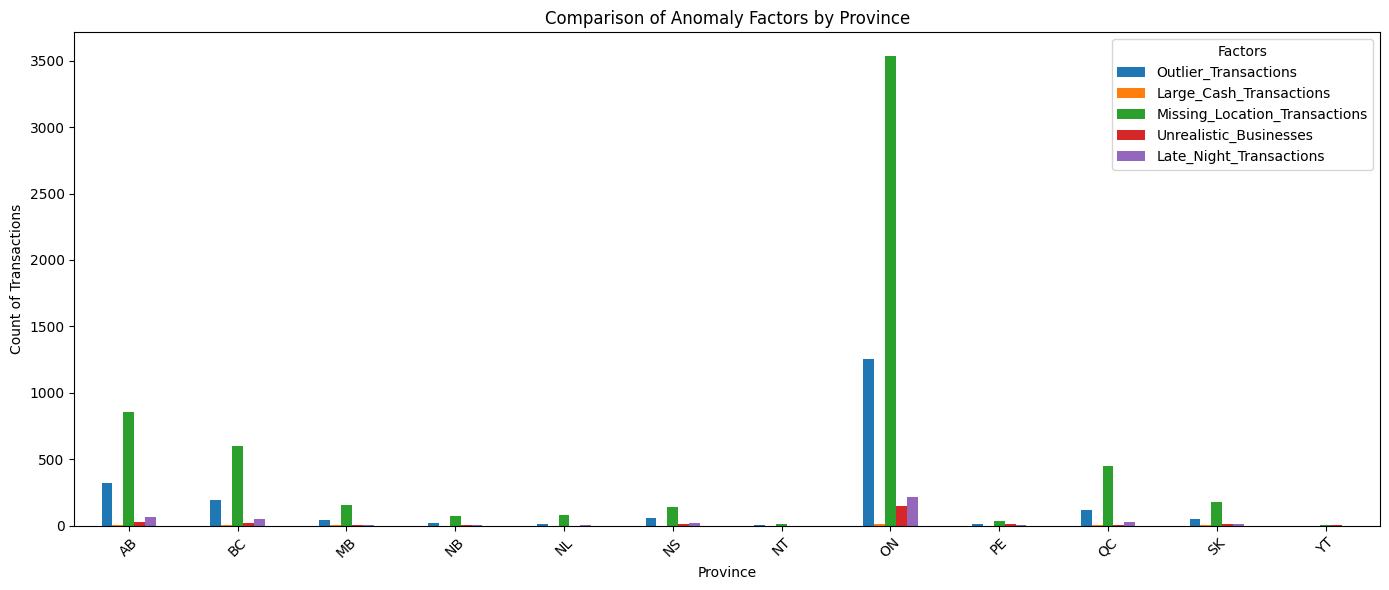

<Figure size 1400x600 with 0 Axes>

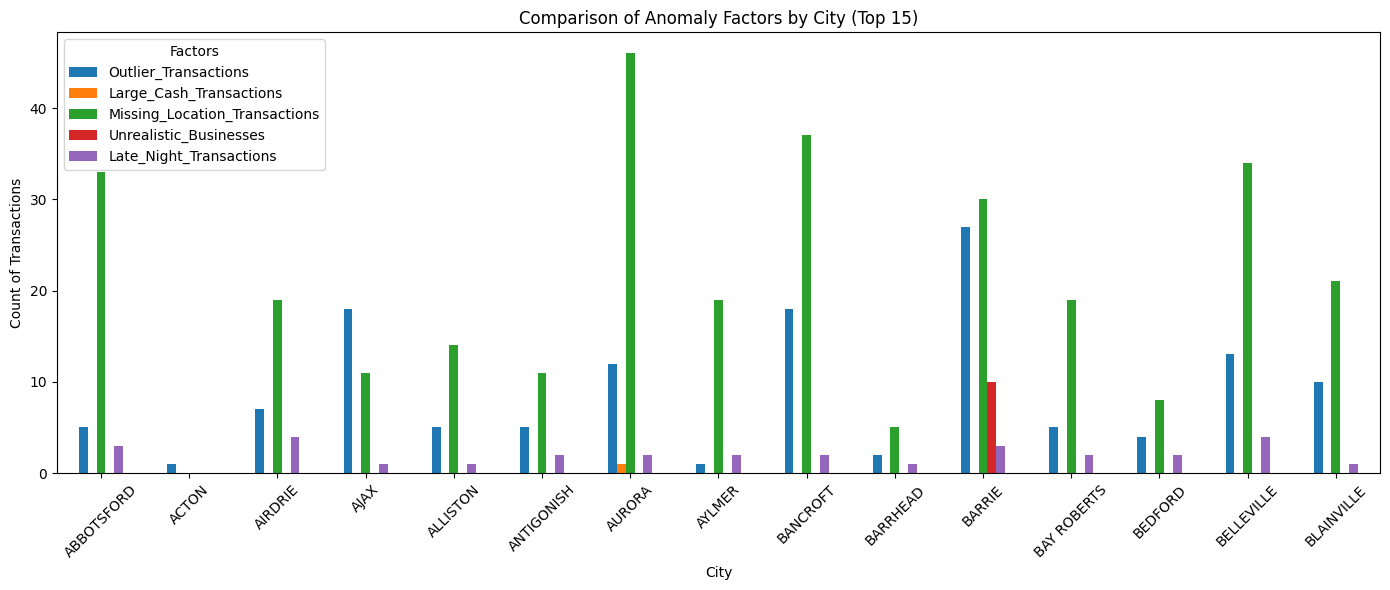

<Figure size 1400x600 with 0 Axes>

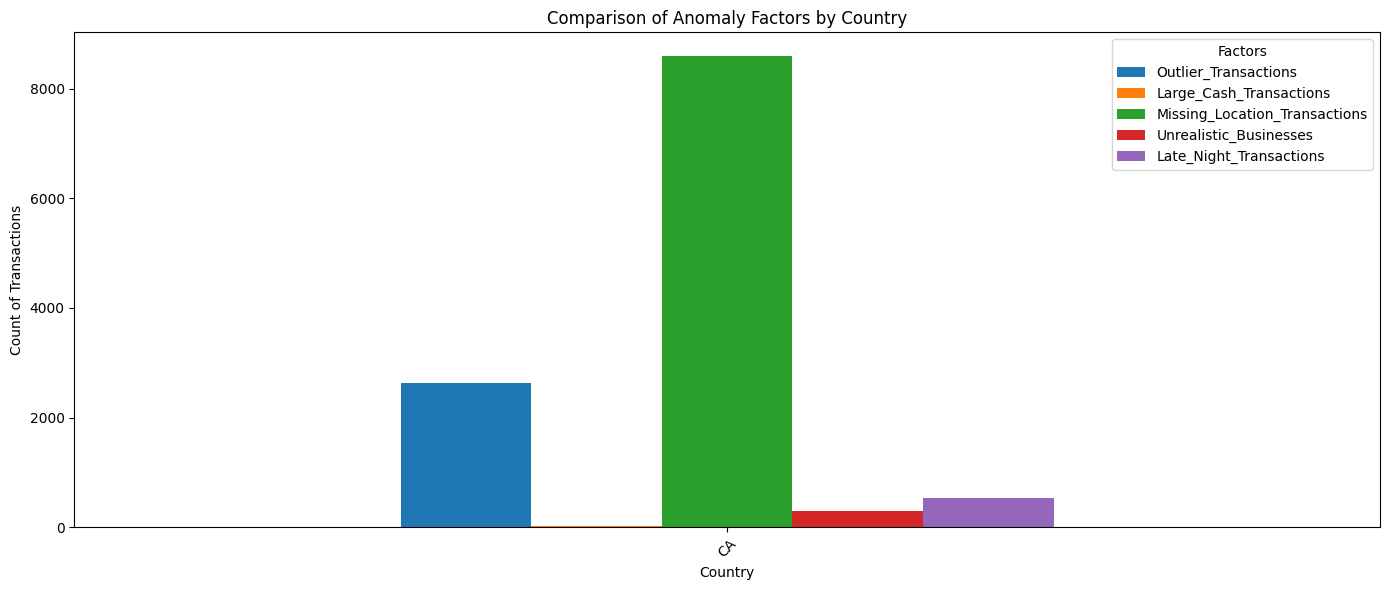

In [157]:
# Summarizing outlier transactions by location
outliers_by_province = outliers['province_1'].value_counts().reset_index()
outliers_by_province.columns = ['Province', 'Outlier_Transactions']

outliers_by_city = outliers['city_1'].value_counts().reset_index()
outliers_by_city.columns = ['City', 'Outlier_Transactions']

outliers_by_country = outliers['country_1'].value_counts().reset_index()
outliers_by_country.columns = ['Country', 'Outlier_Transactions']

# Summarizing large cash transactions by location
large_cash_by_province = large_cash_transactions['province_1'].value_counts().reset_index()
large_cash_by_province.columns = ['Province', 'Large_Cash_Transactions']

large_cash_by_city = large_cash_transactions['city_1'].value_counts().reset_index()
large_cash_by_city.columns = ['City', 'Large_Cash_Transactions']

large_cash_by_country = large_cash_transactions['country_1'].value_counts().reset_index()
large_cash_by_country.columns = ['Country', 'Large_Cash_Transactions']

# Summarizing missing location transactions by location
missing_location_by_province = missing_location['province_1'].value_counts().reset_index()
missing_location_by_province.columns = ['Province', 'Missing_Location_Transactions']

missing_location_by_city = missing_location['city_1'].value_counts().reset_index()
missing_location_by_city.columns = ['City', 'Missing_Location_Transactions']

missing_location_by_country = missing_location['country_1'].value_counts().reset_index()
missing_location_by_country.columns = ['Country', 'Missing_Location_Transactions']

# Summarizing unrealistic business profiles by location
unrealistic_business_by_province = unrealistic_businesses['province_1'].value_counts().reset_index()
unrealistic_business_by_province.columns = ['Province', 'Unrealistic_Businesses']

unrealistic_business_by_city = unrealistic_businesses['city_1'].value_counts().reset_index()
unrealistic_business_by_city.columns = ['City', 'Unrealistic_Businesses']

unrealistic_business_by_country = unrealistic_businesses['country_1'].value_counts().reset_index()
unrealistic_business_by_country.columns = ['Country', 'Unrealistic_Businesses']

# Summarizing late night transactions by location
late_night_by_province = late_night_transactions['province_1'].value_counts().reset_index()
late_night_by_province.columns = ['Province', 'Late_Night_Transactions']

late_night_by_city = late_night_transactions['city_1'].value_counts().reset_index()
late_night_by_city.columns = ['City', 'Late_Night_Transactions']

late_night_by_country = late_night_transactions['country_1'].value_counts().reset_index()
late_night_by_country.columns = ['Country', 'Late_Night_Transactions']

# Function to plot grouped bar charts
def plot_grouped_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(14, 6))
    data.plot(kind='bar', stacked=False, figsize=(14, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title="Factors")
    plt.tight_layout()
    plt.show()

# Merging all factors for visualization at different location levels
province_factors = outliers_by_province.merge(large_cash_by_province, on="Province", how="outer")\
                                      .merge(missing_location_by_province, on="Province", how="outer")\
                                      .merge(unrealistic_business_by_province, on="Province", how="outer")\
                                      .merge(late_night_by_province, on="Province", how="outer")\
                                      .fillna(0).set_index("Province")

city_factors = outliers_by_city.merge(large_cash_by_city, on="City", how="outer")\
                               .merge(missing_location_by_city, on="City", how="outer")\
                               .merge(unrealistic_business_by_city, on="City", how="outer")\
                               .merge(late_night_by_city, on="City", how="outer")\
                               .fillna(0).set_index("City")

country_factors = outliers_by_country.merge(large_cash_by_country, on="Country", how="outer")\
                                     .merge(missing_location_by_country, on="Country", how="outer")\
                                     .merge(unrealistic_business_by_country, on="Country", how="outer")\
                                     .merge(late_night_by_country, on="Country", how="outer")\
                                     .fillna(0).set_index("Country")

# Plot grouped bar charts for each level
plot_grouped_bar_chart(province_factors, "Comparison of Anomaly Factors by Province", "Province", "Count of Transactions")
plot_grouped_bar_chart(city_factors.head(15), "Comparison of Anomaly Factors by City (Top 15)", "City", "Count of Transactions")
plot_grouped_bar_chart(country_factors, "Comparison of Anomaly Factors by Country", "Country", "Count of Transactions")


# CARD KYC DATA

In [100]:
file_path = "card_kyc.csv"
card_df = pd.read_csv(file_path)

In [101]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35632 entries, 0 to 35631
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   card_trxn_id       35632 non-null  object 
 1   customer_id        35632 non-null  object 
 2   amount_cad         35632 non-null  float64
 3   debit_credit       35632 non-null  object 
 4   merchant_category  35632 non-null  object 
 5   ecommerce_ind      35632 non-null  bool   
 6   country            18789 non-null  object 
 7   province           18521 non-null  object 
 8   city               30278 non-null  object 
 9   transaction_date   35632 non-null  object 
 10  transaction_time   35632 non-null  object 
 11  trans_id           35632 non-null  object 
 12  customer_id_1      35632 non-null  object 
 13  country_1          35632 non-null  object 
 14  province_1         24880 non-null  object 
 15  city_1             34142 non-null  object 
 16  industry_code      356

In [102]:
card_df.head()

card_trxn_id       customer_id  amount_cad debit_credit  \
0  CON00000000000434490  SYNCID0000012871       59.42        debit   
1  CON00000000000448433  SYNCID0000013293      130.07        debit   
2  CON00000000000551946  SYNCID0000016433       72.21        debit   
3  CON00000000000130358  SYNCID0000003967        0.00        debit   
4  CON00000000000474006  SYNCID0000014077      148.37        debit   

  merchant_category  ecommerce_ind country province   city transaction_date  \
0              4215          False     NaN      NaN  other       2022-11-07   
1              4215          False     NaN      NaN  other       2023-01-18   
2              4215          False     NaN      NaN  other       2022-11-02   
3              4722          False     NaN      NaN  other       2022-12-15   
4              4812          False     NaN      NaN  other       2023-01-20   

   ... country_1 province_1       city_1 industry_code employee_count  \
0  ...        CA         ON       BOLTON          7599            1.0   
1  ...        CA         ON   GLOUCESTER          9931            0.0   
2  ...        CA         ON      TORONTO          9931            0.0   
3  ...        CA         AB     BARRHEAD          9221            1.0   
4  ...        CA         ON  MISSISSAUGA          4569            2.0   

      sales  established_date  onboard_date  industry_code_1  \
0   79616.0        2006-10-24    2006-11-02           7599.0   
1       0.0        2019-03-03    2019-11-26           9931.0   
2       0.0        2008-07-18    2017-02-07           9931.0   
3       0.0               NaN    2019-12-26           9221.0   
4  182943.0        2011-09-18           NaN           4569.0   

                           industry  
0       Other Real Estate Operators  
1                     Photographers  
2                     Photographers  
3     Taverns, Bars and Night Clubs  
4  Other Truck Transport Industries  

[5 rows x 23 columns]

In [103]:
# Identify extreme transaction amounts
high_threshold = card_df['amount_cad'].quantile(0.99)  # Top 1% transactions
low_threshold = card_df['amount_cad'].quantile(0.01)   # Bottom 1% transactions

# Extract high and low transactions
high_transactions = card_df[card_df['amount_cad'] > high_threshold]
low_transactions = card_df[card_df['amount_cad'] < low_threshold]

# Display high and low transaction statistics
high_transactions_summary = high_transactions.describe()
low_transactions_summary = low_transactions.describe()

print("High Transaction Outliers Summary")
display(high_transactions_summary)
print("\nLow Transaction Outliers Summary")
display(low_transactions_summary)

High Transaction Outliers Summary


amount_cad  industry_code  employee_count         sales  \
count     357.000000     357.000000      309.000000  3.240000e+02   
mean    14986.740700    6025.378151        1.695793  1.904593e+05   
std     31304.335567    3070.659364        1.908120  4.069273e+05   
min      4264.470000     115.000000        0.000000  0.000000e+00   
25%      5279.990000    4224.000000        1.000000  0.000000e+00   
50%      7399.020000    6312.000000        1.000000  4.142800e+04   
75%     12661.320000    9141.000000        2.000000  1.755990e+05   
max    300045.650000    9999.000000       15.000000  3.431923e+06   

       industry_code_1  
count       313.000000  
mean       6819.431310  
std        2369.898169  
min        1072.000000  
25%        4278.000000  
50%        6521.000000  
75%        9221.000000  
max        9999.000000


Low Transaction Outliers Summary


amount_cad  industry_code  employee_count         sales  \
count    275.000000     275.000000      240.000000  2.440000e+02   
mean    -624.465527    6083.763636        2.037500  2.308515e+05   
std     2721.449790    2876.158574        2.842197  5.145881e+05   
min   -27855.310000     112.000000        0.000000  0.000000e+00   
25%     -226.630000    4232.000000        1.000000  0.000000e+00   
50%      -76.680000    6231.000000        1.000000  7.746650e+04   
75%      -30.370000    8641.000000        2.000000  1.755082e+05   
max       -0.260000    9999.000000       20.000000  5.646966e+06   

       industry_code_1  
count       248.000000  
mean       6705.020161  
std        2285.000717  
min        1072.000000  
25%        4278.750000  
50%        6466.500000  
75%        8668.250000  
max        9999.000000

Findings from Extreme Transactions
High-Value Transactions (Top 1%)

357 transactions exceed the 99th percentile, with an average amount of $14,986 CAD.
The highest transaction recorded is $300,045 CAD.
These transactions are linked to various industries, with some businesses having zero employees yet handling high amounts, which may indicate potential fraud.
Low-Value Transactions (Bottom 1%)

275 transactions fall below the 1st percentile, with negative amounts (potential chargebacks or reversals).
The lowest transaction recorded is -27,855 CAD.
Some cases show negative balances combined with businesses having no sales, which could be an anomaly.

In [104]:
# Identify customers with the highest number of transactions
customer_transaction_counts = card_df['customer_id'].value_counts()

# Display customers with unusually high transaction counts
high_transaction_customers = customer_transaction_counts[customer_transaction_counts > customer_transaction_counts.quantile(0.99)]

# Extract details of these customers
high_freq_customers_df = card_df[card_df['customer_id'].isin(high_transaction_customers.index)]

print("High Freqyency Transaction Customers")
display(high_freq_customers_df)

# Show top 10 most frequent customers
high_transaction_customers.head(10)

High Freqyency Transaction Customers


card_trxn_id       customer_id  amount_cad debit_credit  \
6      CON00000000000081817  SYNCID0000002403        0.00        debit   
29     CON00000000000132961  SYNCID0000004028       52.82        debit   
47     CON00000000000482130  SYNCID0000014302      581.28        debit   
63     CON00000000000220537  SYNCID0000006636       26.93        debit   
73     CON00000000000443255  SYNCID0000013136       12.09        debit   
...                     ...               ...         ...          ...   
35590  CON00000000000442922  SYNCID0000013136      169.01        debit   
35593  CON00000000000094090  SYNCID0000002751       53.41        debit   
35609  CON00000000000497205  SYNCID0000014771       12.87        debit   
35612  CON00000000000486727  SYNCID0000014441        2.49        debit   
35629  CON00000000000357717  SYNCID0000010578      601.48        debit   

      merchant_category  ecommerce_ind country province       city  \
6                  4816          False     NaN      NaN      other   
29                 5251          False     NaN      NaN      other   
47                 5300          False     NaN      NaN      other   
63                 5411          False     NaN      NaN      other   
73                 5411          False     NaN      NaN      other   
...                 ...            ...     ...      ...        ...   
35590              5300          False      CA       ON  BRANTFORD   
35593              5310          False      CA       ON     NEPEAN   
35609              5411          False      CA       ON    TIMMINS   
35612              5411          False      CA       ON    TORONTO   
35629              5533          False      CA       ON  PICKERING   

      transaction_date  ... country_1 province_1       city_1 industry_code  \
6           2023-01-12  ...        CA         ON      MARKHAM          6593   
29          2022-11-05  ...        CA         ON        other          9614   
47          2023-01-13  ...        CA         QC        LAVAL          7211   
63          2022-11-30  ...        CA        NaN        other          8132   
73          2022-11-28  ...        CA         NB  FREDERICTON          6591   
...                ...  ...       ...        ...          ...           ...   
35590       2022-11-29  ...        CA         NB  FREDERICTON          6591   
35593       2022-12-01  ...        CA         AB      CAMROSE          7711   
35609       2023-01-09  ...        CA        NaN        other          5622   
35612       2022-12-06  ...        CA         AB      CALGARY          4799   
35629       2022-11-01  ...        CA         ON       BARRIE          9949   

      employee_count     sales  established_date  onboard_date  \
6                2.0  262686.0        2011-12-16    2011-12-29   
29               0.0       0.0        1997-03-08    1997-07-24   
47               1.0   14734.0        2021-02-08           NaN   
63               NaN  175599.0        2019-07-20    2020-12-21   
73               1.0   91541.0        1991-09-14    1991-12-20   
...              ...       ...               ...           ...   
35590            1.0   91541.0        1991-09-14    1991-12-20   
35593            1.0  181309.0        1978-03-06           NaN   
35609            2.0   94043.0        2012-05-19    2019-10-04   
35612            1.0       0.0        2022-02-12    2022-08-15   
35629            1.0   59139.0        2010-09-16    2020-03-19   

       industry_code_1                                           industry  
6               6593.0           Art Galleries and Artists' Supply Stores  
29              9614.0                           Sound Recording Services  
47              7211.0                          Investment (Mutual) Funds  
63              8132.0                               Immigration Services  
73              6591.0              Second-Hand Merchandise Stores n.e.c.  
...                ...                                                ...  
35590      

customer_id
SYNCID0000005234    166
SYNCID0000006636    165
SYNCID0000004513    162
SYNCID0000013136    160
SYNCID0000014771    160
SYNCID0000001299    141
SYNCID0000010578    141
SYNCID0000013129    136
SYNCID0000004028    133
SYNCID0000004433    123
Name: count, dtype: int64

Frequent Transaction Customers Analysis
Some customers have an unusually high number of transactions compared to others.
The top customer (SYNCID0000005234) has 166 transactions, while several others have over 120 transactions.
These customers could indicate:
Money laundering (rapid cycling of funds).
Bot-like behavior (high-frequency transactions in a short period).
Business entities making legitimate bulk transactions.

In [105]:
# Identify top merchant categories associated with high transactions
high_transactions_merchant = high_transactions['merchant_category'].value_counts()

# Identify top merchant categories associated with low transactions
low_transactions_merchant = low_transactions['merchant_category'].value_counts()

print("High Transaction Merchant Categories")
display(high_transactions_merchant)
print("\nLow Transaction Merchant Categories")
display(low_transactions_merchant)

High Transaction Merchant Categories


merchant_category
other    217
5047      17
5251       9
5200       8
5511       6
5085       6
6300       6
7311       5
4900       5
5300       5
9399       4
5045       4
5533       4
5712       4
7538       4
5651       4
5310       3
5541       3
7011       3
7542       3
5732       3
5968       3
7523       3
7372       3
4215       3
5411       2
5039       2
5734       2
5655       1
5814       1
8699       1
4816       1
5921       1
5912       1
5211       1
4899       1
5815       1
5942       1
8099       1
5499       1
5691       1
5943       1
5542       1
4121       1
Name: count, dtype: int64


Low Transaction Merchant Categories


merchant_category
other    46
5251     40
5200     31
5542     22
5411     20
5541     13
5310     12
5814      9
5734      8
5812      6
7399      5
7523      4
5300      4
5085      4
9399      4
5968      3
7311      3
5047      3
5921      3
5331      3
5211      3
4816      3
4814      2
5499      2
5818      2
4121      2
5815      2
4215      2
6300      2
5039      1
5816      1
5511      1
5533      1
8099      1
5655      1
7538      1
5045      1
5912      1
7011      1
4899      1
4812      1
Name: count, dtype: int64

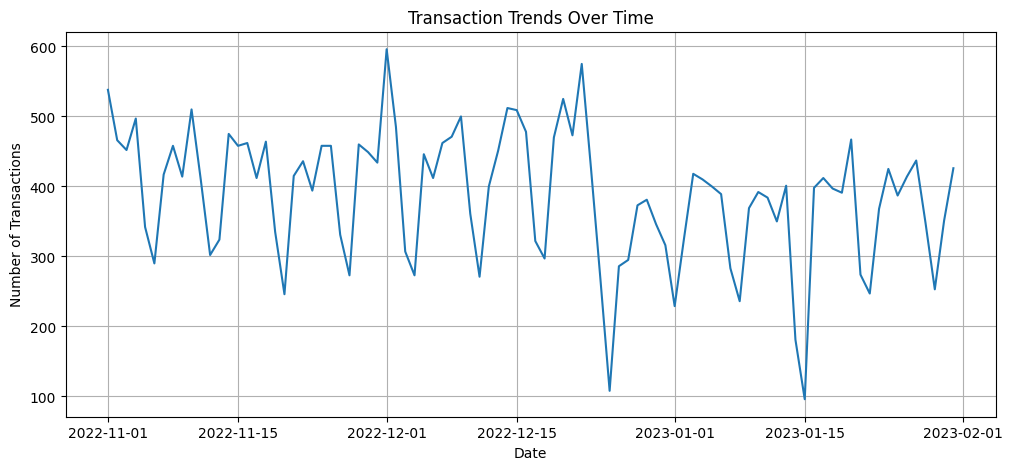

In [106]:
card_df['transaction_date'] = pd.to_datetime(card_df['transaction_date'])

# Aggregate transaction counts by date
transaction_trends = card_df.groupby('transaction_date').size()

# Plot transaction trend over time
plt.figure(figsize=(12, 5))
sns.lineplot(x=transaction_trends.index, y=transaction_trends.values)
plt.title("Transaction Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

In [107]:
# Aggregate high and low transactions by country
high_transaction_countries = high_transactions['country'].value_counts()
low_transaction_countries = low_transactions['country'].value_counts()

# Show top 10 countries for high and low transactions
high_transaction_countries.head(10), low_transaction_countries.head(10)

(country
 CA    184
 US      2
 GB      1
 Name: count, dtype: int64,
 country
 CA    174
 GB      2
 IE      1
 SE      1
 US      1
 Name: count, dtype: int64)

<ipython-input-108-2c0e1553ca47>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values, palette="Blues_r")


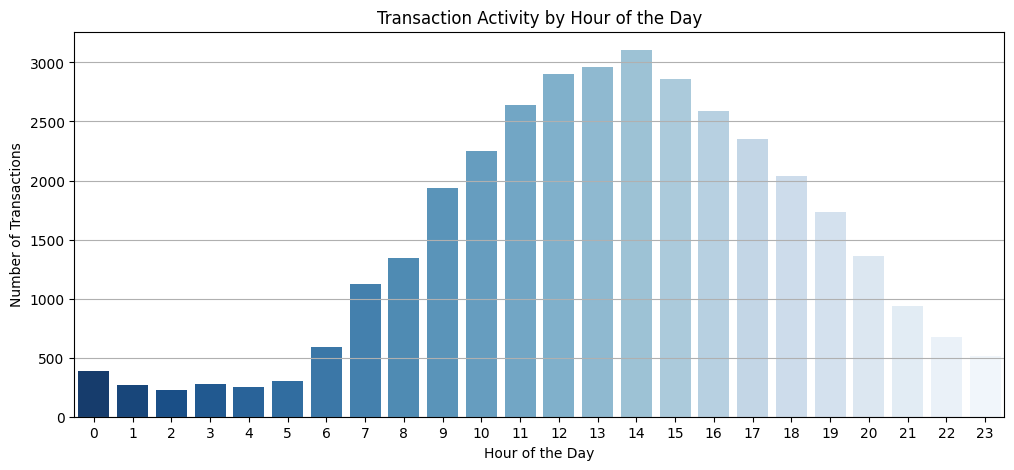

In [108]:
# Convert transaction_time to datetime format (assuming HH:MM:SS format)
card_df['transaction_time'] = pd.to_datetime(card_df['transaction_time'], format='%H:%M:%S').dt.hour

# Aggregate transactions by hour
hourly_transactions = card_df['transaction_time'].value_counts().sort_index()

# Plot transactions by hour
plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values, palette="Blues_r")
plt.title("Transaction Activity by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

In [109]:
# Identify customers with repeated transactions at odd hours (midnight to 5 AM)
odd_hour_transactions = card_df[card_df['transaction_time'].between(0, 5)]

# Count transactions per customer during odd hours
odd_hour_customers = odd_hour_transactions['customer_id'].value_counts()

# Filter customers with unusually high odd-hour transactions (top 1%)
high_odd_hour_customers = odd_hour_customers[odd_hour_customers > odd_hour_customers.quantile(0.99)]

# Extract transactions for these customers
high_odd_hour_transactions = card_df[card_df['customer_id'].isin(high_odd_hour_customers.index)]

# Show top 10 customers transacting at odd hours
high_odd_hour_customers.head(10)

customer_id
SYNCID0000011960    10
SYNCID0000004513     9
SYNCID0000014302     8
SYNCID0000012078     8
SYNCID0000002751     8
SYNCID0000014771     8
Name: count, dtype: int64

In [110]:
from sklearn.cluster import KMeans
import numpy as np

# Select relevant features for clustering
customer_spending = card_df.groupby('customer_id').agg({
    'amount_cad': ['sum', 'mean', 'count'],  # Total, average, and count of transactions
    'transaction_time': 'mean'  # Average hour of transaction
}).reset_index()

# Rename columns
customer_spending.columns = ['customer_id', 'total_spent', 'avg_spent', 'transaction_count', 'avg_transaction_hour']

# Fill any missing values
customer_spending.fillna(0, inplace=True)

# Normalize data for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_spending[['total_spent', 'avg_spent', 'transaction_count', 'avg_transaction_hour']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_spending['cluster'] = kmeans.fit_predict(scaled_data)

customer_spending


customer_id  total_spent   avg_spent  transaction_count  \
0     SYNCID0000000004      3011.84  215.131429                 14   
1     SYNCID0000000019      1210.42  151.302500                  8   
2     SYNCID0000000023      1989.11  165.759167                 12   
3     SYNCID0000000033      5572.43  179.755806                 31   
4     SYNCID0000000034       795.83  132.638333                  6   
...                ...          ...         ...                ...   
2472  SYNCID0000017157        47.18   15.726667                  3   
2473  SYNCID0000017158       264.55  264.550000                  1   
2474  SYNCID0000017165        14.03   14.030000                  1   
2475  SYNCID0000017170      2448.29  612.072500                  4   
2476  SYNCID0000017175      1343.16  149.240000                  9   

      avg_transaction_hour  cluster  
0                14.000000        1  
1                13.500000        1  
2                14.166667        1  
3                13.129032        1  
4                13.333333        1  
...                    ...      ...  
2472             17.000000        1  
2473             16.000000        1  
2474             15.000000        1  
2475             14.000000        1  
2476             11.555556        1  

[2477 rows x 6 columns]

In [111]:
# Identify duplicate transactions (same amount, same merchant, same customer, within short time)
card_df['transaction_date_time'] = pd.to_datetime(card_df['transaction_date'].astype(str) + ' ' + card_df['transaction_time'].astype(str))

# Sort data by customer and transaction time
card_df = card_df.sort_values(by=['customer_id', 'transaction_date_time'])

# Identify transactions occurring within a short interval (e.g., 5 minutes)
card_df['time_diff'] = card_df.groupby('customer_id')['transaction_date_time'].diff().dt.total_seconds()

# Flag duplicate transactions (same amount, same merchant, within 5 minutes)
duplicate_transactions = card_df[(card_df['time_diff'] <= 300) & (card_df['time_diff'] > 0) & card_df.duplicated(subset=['customer_id', 'amount_cad', 'merchant_category'], keep=False)]

duplicate_transactions

Empty DataFrame
Columns: [card_trxn_id, customer_id, amount_cad, debit_credit, merchant_category, ecommerce_ind, country, province, city, transaction_date, transaction_time, trans_id, customer_id_1, country_1, province_1, city_1, industry_code, employee_count, sales, established_date, onboard_date, industry_code_1, industry, transaction_date_time, time_diff]
Index: []

[0 rows x 25 columns]

In [112]:
# Inspect unique values in the transaction_time column
unique_times = card_df['transaction_time'].unique()

# Display first 20 unique values to identify inconsistencies
unique_times[:20]

array([15, 17,  9, 12, 19, 10, 18,  8, 13,  6, 16, 14,  2,  3,  7, 23,  0,
       21, 11, 22], dtype=int32)

<ipython-input-113-aea117280161>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


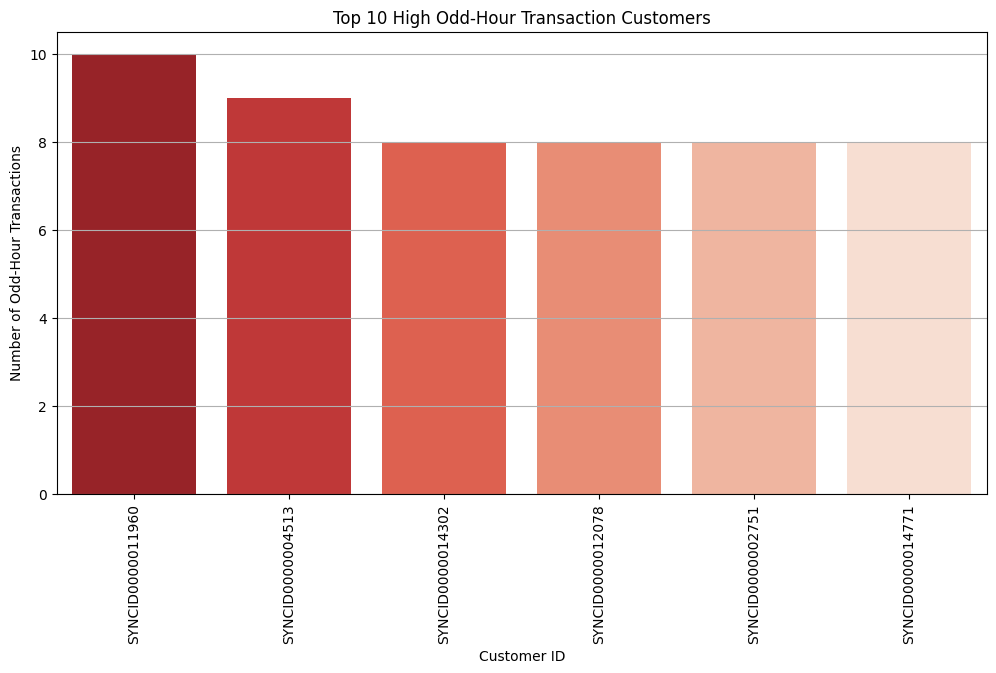

In [113]:
# Visualizing High Odd-Hour Transaction Customers
# Extracting the high odd-hour customers for visualization
odd_hour_transactions_filtered = card_df[card_df['customer_id'].isin(high_odd_hour_customers.index)]

# Count of transactions per high odd-hour customer
plt.figure(figsize=(12, 6))
sns.barplot(
    x=high_odd_hour_customers.index[:10],
    y=high_odd_hour_customers.values[:10],
    palette="Reds_r"
)
plt.xticks(rotation=90)
plt.title("Top 10 High Odd-Hour Transaction Customers")
plt.xlabel("Customer ID")
plt.ylabel("Number of Odd-Hour Transactions")
plt.grid(axis='y')
plt.show()


customer segmentation based on total spending (CAD) vs. transaction count.

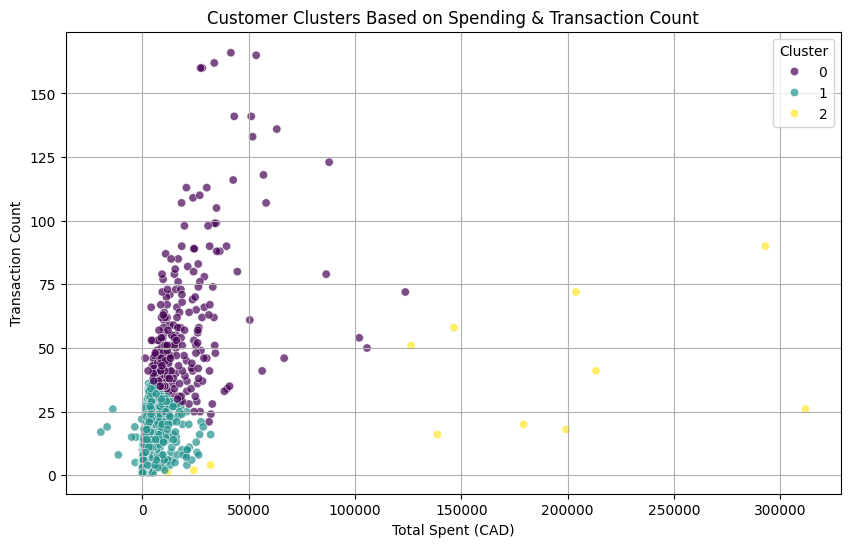

In [114]:
# Visualizing customer clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_spending['total_spent'],
    y=customer_spending['transaction_count'],
    hue=customer_spending['cluster'],
    palette="viridis",
    alpha=0.7
)
plt.title("Customer Clusters Based on Spending & Transaction Count")
plt.xlabel("Total Spent (CAD)")
plt.ylabel("Transaction Count")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [115]:
# Correlate flagged high-risk customers with industry categories
high_risk_customers = customer_spending[customer_spending['cluster'] == 2]  # Assuming cluster 2 is high-risk

# Merge with original dataset to get industry details
high_risk_industries = high_risk_customers.merge(card_df[['customer_id', 'industry']], on='customer_id', how='left')

# Count occurrences of industries among high-risk customers
industry_counts = high_risk_industries['industry'].value_counts()

industry_counts.head(10)

industry
Institutional Building                                                      90
Other Transportation Industries n.e.c.                                      72
Used Goods Moving and Storage Industry                                      58
Other Real Estate Operators                                                 51
Other Interior and Finishing Work                                           41
Boat Rentals and Marinas                                                    26
Plumbing, Heating and Air Conditioning Equipment and Supplies, Wholesale    20
Drywall Work                                                                18
Glass and Glazing Work                                                      16
Child Day-Care and Nursery School Services                                   4
Name: count, dtype: int64

<ipython-input-116-17f85ccaeb2f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=industry_counts.index[:10], x=industry_counts.values[:10], palette="coolwarm")


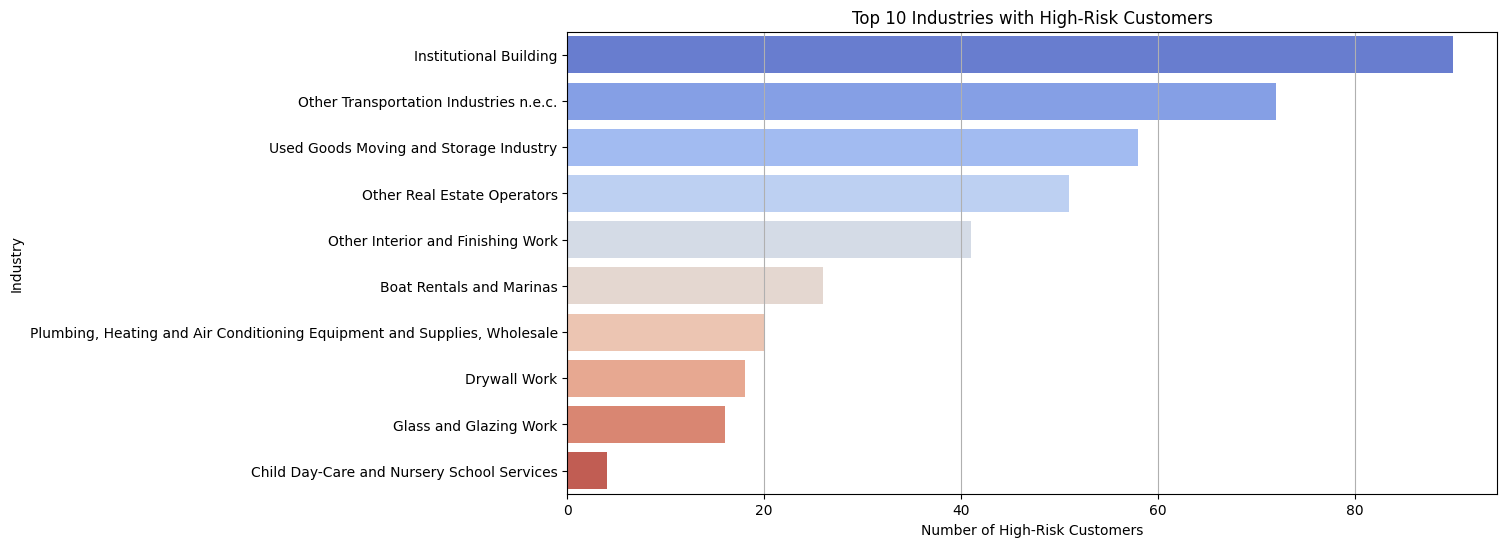

In [116]:
# Visualizing the distribution of industries among high-risk customers
plt.figure(figsize=(12, 6))
sns.barplot(y=industry_counts.index[:10], x=industry_counts.values[:10], palette="coolwarm")
plt.title("Top 10 Industries with High-Risk Customers")
plt.xlabel("Number of High-Risk Customers")
plt.ylabel("Industry")
plt.grid(axis='x')
plt.show()


In [117]:
# Identify customers with high spending but low business legitimacy (zero employees, low revenue)
high_spending_low_legitimacy = customer_spending.merge(
    card_df[['customer_id', 'employee_count', 'sales', 'industry']], on='customer_id', how='left'
)

# Filter for customers with high total spending but zero employees or low revenue
suspicious_customers = high_spending_low_legitimacy[
    (high_spending_low_legitimacy['total_spent'] > high_spending_low_legitimacy['total_spent'].quantile(0.95)) &
    ((high_spending_low_legitimacy['employee_count'] == 0) | (high_spending_low_legitimacy['sales'] < 10000))
]

suspicious_customers.head()

customer_id  total_spent   avg_spent  transaction_count  \
7819  SYNCID0000004028     51843.68  389.802105                133   
7820  SYNCID0000004028     51843.68  389.802105                133   
7821  SYNCID0000004028     51843.68  389.802105                133   
7822  SYNCID0000004028     51843.68  389.802105                133   
7823  SYNCID0000004028     51843.68  389.802105                133   

      avg_transaction_hour  cluster  employee_count  sales  \
7819             12.616541        0             0.0    0.0   
7820             12.616541        0             0.0    0.0   
7821             12.616541        0             0.0    0.0   
7822             12.616541        0             0.0    0.0   
7823             12.616541        0             0.0    0.0   

                      industry  
7819  Sound Recording Services  
7820  Sound Recording Services  
7821  Sound Recording Services  
7822  Sound Recording Services  
7823  Sound Recording Services

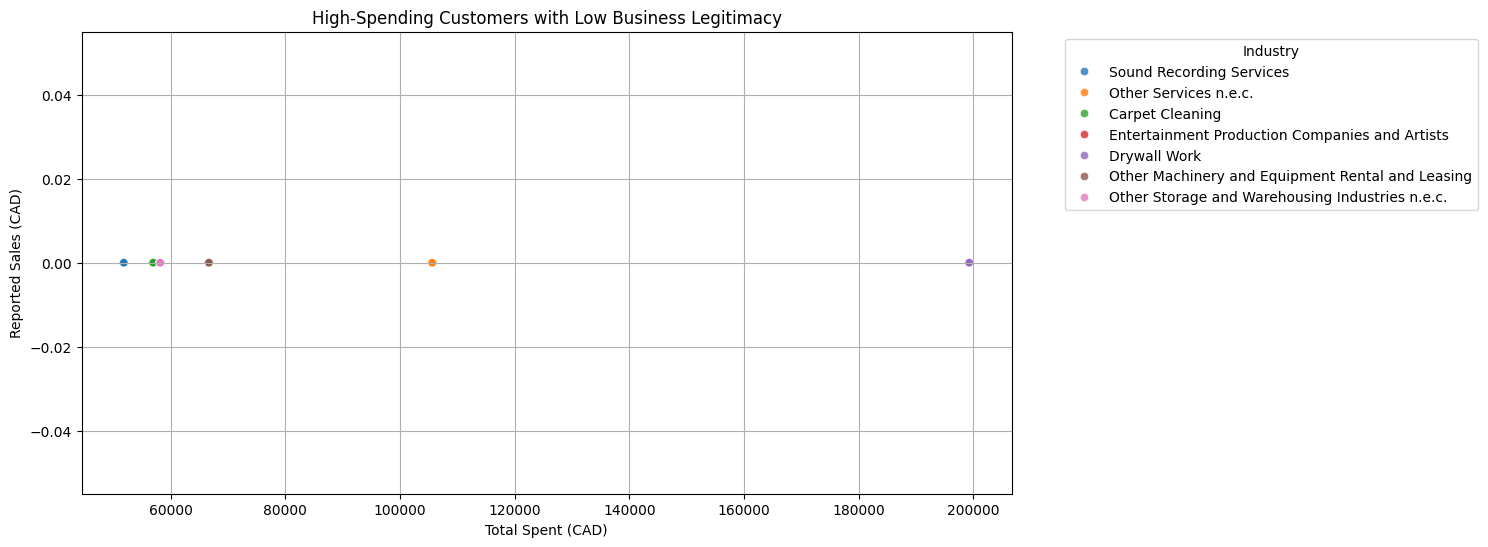

In [118]:
# Visualizing these customers
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=suspicious_customers['total_spent'],
    y=suspicious_customers['sales'],
    hue=suspicious_customers['industry'],
    palette="tab10",
    alpha=0.8
)
plt.title("High-Spending Customers with Low Business Legitimacy")
plt.xlabel("Total Spent (CAD)")
plt.ylabel("Reported Sales (CAD)")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [119]:
import pandas as pd

# Load the CSV files
try:
  card_df = pd.read_csv('abm.csv')
  cheque_df = pd.read_csv('cheque.csv')

  # Print the column names
  print("Card DataFrame Columns:")
  print(card_df.columns)
  print("\nCheque DataFrame Columns:")
  print(cheque_df.columns)

except FileNotFoundError:
  print("One or both of the CSV files ('card.csv', 'cheque.csv') were not found.")
except pd.errors.EmptyDataError:
  print("One or both of the CSV files are empty.")
except pd.errors.ParserError:
  print("Error parsing one or both of the CSV files.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Card DataFrame Columns:
Index(['abm_id', 'customer_id', 'amount_cad', 'debit_credit', 'cash_indicator',
       'country', 'province', 'city', 'transaction_date', 'transaction_time'],
      dtype='object')

Cheque DataFrame Columns:
Index(['cheque_id', 'customer_id', 'amount_cad', 'debit_credit',
       'transaction_date'],
      dtype='object')


# Cheque Dataset

In [120]:
cheque_file_path = "cheque_kyc.csv"
cheque_df = pd.read_csv(cheque_file_path)

In [121]:
cheque_df.head()

cheque_id       customer_id  amount_cad debit_credit  \
0  CHE00000000000000350  SYNCID0000000019     1348.35        debit   
1  CHE00000000000053534  SYNCID0000003464     6541.64        debit   
2  CHE00000000000068459  SYNCID0000004383      269.73        debit   
3  CHE00000000000069306  SYNCID0000004393     1160.74        debit   
4  CHE00000000000091820  SYNCID0000005938    42724.42        debit   

  transaction_date              trans_id     customer_id_1 country province  \
0       2022-11-01  CHE00000000000000350  SYNCID0000000019      CA       BC   
1       2022-11-01  CHE00000000000053534  SYNCID0000003464      CA      NaN   
2       2022-11-01  CHE00000000000068459  SYNCID0000004383      CA       AB   
3       2022-11-01  CHE00000000000069306  SYNCID0000004393      CA       ON   
4       2022-11-01  CHE00000000000091820  SYNCID0000005938      CA       QC   

         city  industry_code  employee_count     sales established_date  \
0   COQUITLAM            112             1.0  214530.0       2021-07-06   
1       other           4931             2.0   93420.0       1998-01-02   
2     CALGARY            219             1.0       NaN              NaN   
3      BARRIE           6582             0.0       0.0       2009-11-10   
4  TERREBONNE            141             1.0       NaN       1976-12-18   

  onboard_date  industry_code_1                           industry  
0          NaN              NaN                                NaN  
1   2018-07-22           4931.0             Water Systems Industry  
2   1999-12-30              NaN                                NaN  
3   2009-12-11           6582.0  Gift, Novelty and Souvenir Stores  
4   2000-05-18              NaN                                NaN

In [122]:
cheque_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43015 entries, 0 to 43014
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cheque_id         43015 non-null  object 
 1   customer_id       43015 non-null  object 
 2   amount_cad        43015 non-null  float64
 3   debit_credit      43015 non-null  object 
 4   transaction_date  43015 non-null  object 
 5   trans_id          43015 non-null  object 
 6   customer_id_1     43015 non-null  object 
 7   country           43015 non-null  object 
 8   province          29922 non-null  object 
 9   city              41855 non-null  object 
 10  industry_code     43015 non-null  int64  
 11  employee_count    37380 non-null  float64
 12  sales             38495 non-null  float64
 13  established_date  36109 non-null  object 
 14  onboard_date      36677 non-null  object 
 15  industry_code_1   38049 non-null  float64
 16  industry          38049 non-null  object

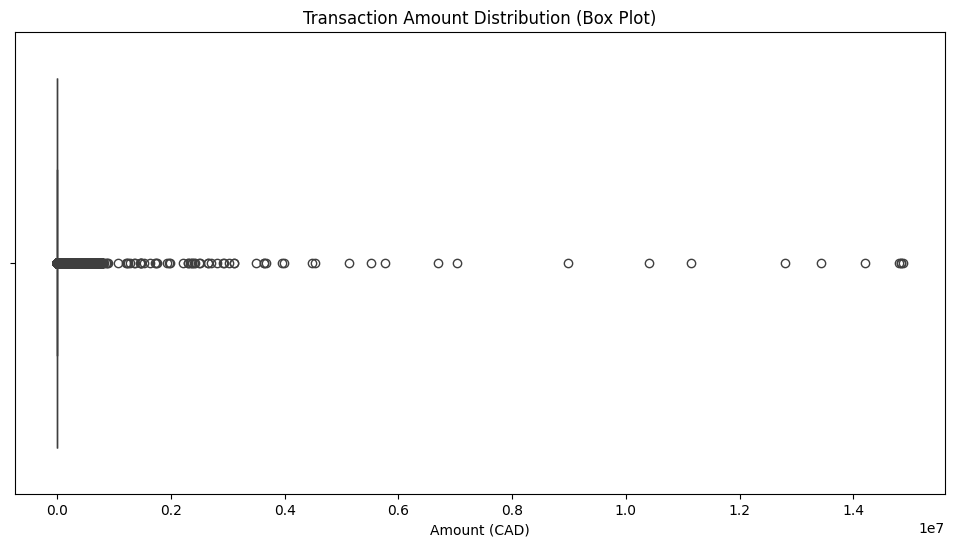

count    4.301500e+04
mean     1.277833e+04
std      2.310832e+05
min      1.000000e-02
25%      3.666100e+02
50%      9.660000e+02
75%      2.482445e+03
max      1.486550e+07
Name: amount_cad, dtype: float64

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of transaction amounts
plt.figure(figsize=(12, 6))
sns.boxplot(x=cheque_df["amount_cad"])
plt.title("Transaction Amount Distribution (Box Plot)")
plt.xlabel("Amount (CAD)")
plt.show()

# Summary statistics for transaction amounts
cheque_df["amount_cad"].describe()

Findings from Transaction Amount Distribution
Min Amount: $0.01 (Very small transactions)
Max Amount: $14,865,500 (Extremely large transaction)
Median: $966 (50% of transactions are below this amount)
Mean: $12,778 (Pulled higher due to extreme values)
75th Percentile: $2,482 (Most transactions are below this amount)

In [124]:
# Group by industry and analyze transaction amounts
industry_analysis = cheque_df.groupby("industry")["amount_cad"].agg(["count", "mean", "median", "max"]).sort_values(by="mean", ascending=False)

# Display the analysis
print("High-Risk Merchant Categories")
industry_analysis.head()


High-Risk Merchant Categories


count           mean  \
industry                                                                   
Patent Medicine and Toiletries Stores                 315  124897.604413   
Professional Machinery, Equipment and Supplies,...     48  122375.066458   
Other Motor Vehicle Parts and Accessories, Whol...    117  113984.315726   
Water Systems Industry                                157   92506.784586   
Direct Sellers                                        649   82803.304037   

                                                      median          max  
industry                                                                   
Patent Medicine and Toiletries Stores               1411.610  14808789.80  
Professional Machinery, Equipment and Supplies,...   926.875   5131415.89  
Other Motor Vehicle Parts and Accessories, Whol...   936.680  11150273.18  
Water Systems Industry                              1380.200   7037942.20  
Direct Sellers                                      1012.840  14831167.99

In [125]:
# Count transactions per customer
customer_transaction_counts = cheque_df["customer_id"].value_counts()

# Identify customers with the highest transaction counts (potential fraud risk)
high_freq_customers = customer_transaction_counts[customer_transaction_counts > customer_transaction_counts.quantile(0.99)]

print("High-Frequency Transaction Customers")
high_freq_customers.head()

High-Frequency Transaction Customers


customer_id
SYNCID0000000844    449
SYNCID0000004383    417
SYNCID0000007214    343
SYNCID0000014570    309
SYNCID0000003782    262
Name: count, dtype: int64

In [126]:
# Group by city and analyze transaction amounts
geo_analysis = cheque_df.groupby("city")["amount_cad"].agg(["count", "mean", "median", "max"]).sort_values(by="mean", ascending=False)

print("Geographic Distribution of High-Risk Transactions")
geo_analysis.head()


Geographic Distribution of High-Risk Transactions


count           mean    median          max
city                                                  
LEVIS         16  801570.325625  1282.845  12790933.61
LONGUEUIL     86  198623.062209  1972.540  13438511.31
SUDBURY      392  145397.534082  1265.720  14865498.37
SARNIA        75  144223.270133  1115.960   6691945.38
ORILLIA       20  133262.634000  1750.085   1736068.90

In [127]:
# Identifying duplicate transactions based on same amount, same customer, and short time interval
cheque_df["transaction_date"] = pd.to_datetime(cheque_df["transaction_date"])

# Sorting for time-based analysis
df_sorted = cheque_df.sort_values(by=["customer_id", "transaction_date"])

# Checking for duplicate transactions with the same amount and same customer in short intervals
df_sorted["time_diff"] = df_sorted.groupby(["customer_id", "amount_cad"])["transaction_date"].diff().dt.days

# Identifying potential duplicate transactions (within 1 day)
duplicate_transactions = df_sorted[df_sorted["time_diff"] == 1]

# Display the suspicious transactions
print("Potential Duplicate Fraud Transactions")
duplicate_transactions.head()

Potential Duplicate Fraud Transactions


Empty DataFrame
Columns: [cheque_id, customer_id, amount_cad, debit_credit, transaction_date, trans_id, customer_id_1, country, province, city, industry_code, employee_count, sales, established_date, onboard_date, industry_code_1, industry, time_diff]
Index: []

Potential Duplicate Fraud Transactions (30-Day Window)


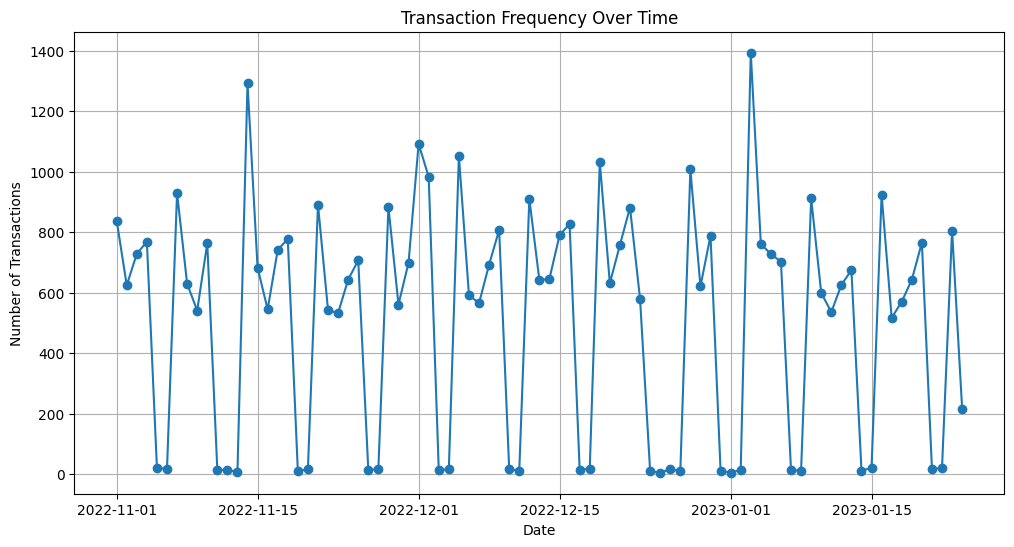

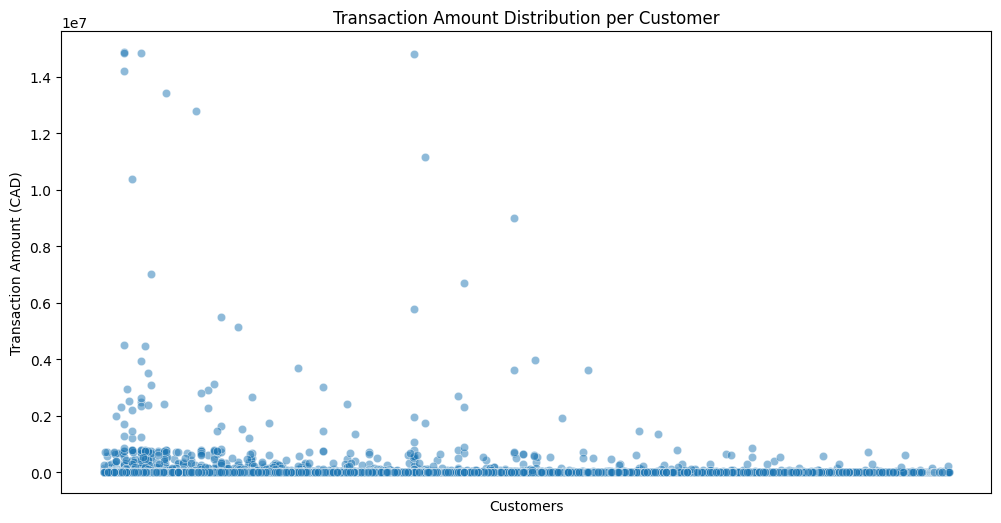

In [128]:
# Identifying duplicate transactions within a 30-day window
duplicate_transactions_month = df_sorted[df_sorted["time_diff"] <= 30]

# Display the potential fraudulent transactions with a wider timeframe
print("Potential Duplicate Fraud Transactions (30-Day Window)")
duplicate_transactions_month.head()

# Visualizing transaction frequency over time
plt.figure(figsize=(12, 6))
cheque_df["transaction_date"].dt.date.value_counts().sort_index().plot(kind="line", marker="o")
plt.title("Transaction Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

# Scatter plot of transaction amount vs. frequency
plt.figure(figsize=(12, 6))
sns.scatterplot(x=cheque_df["customer_id"], y=cheque_df["amount_cad"], alpha=0.5)
plt.xticks([])  # Hide x-axis labels for readability
plt.title("Transaction Amount Distribution per Customer")
plt.xlabel("Customers")
plt.ylabel("Transaction Amount (CAD)")
plt.show()

Near-Duplicate Fraud Transactions (30-Day Window, 5% Variation)
Empty DataFrame
Columns: [cheque_id, customer_id, amount_cad, debit_credit, transaction_date, trans_id, customer_id_1, country, province, city, industry_code, employee_count, sales, established_date, onboard_date, industry_code_1, industry, time_diff, prev_amount, amount_diff, relative_diff]
Index: []

[0 rows x 21 columns]


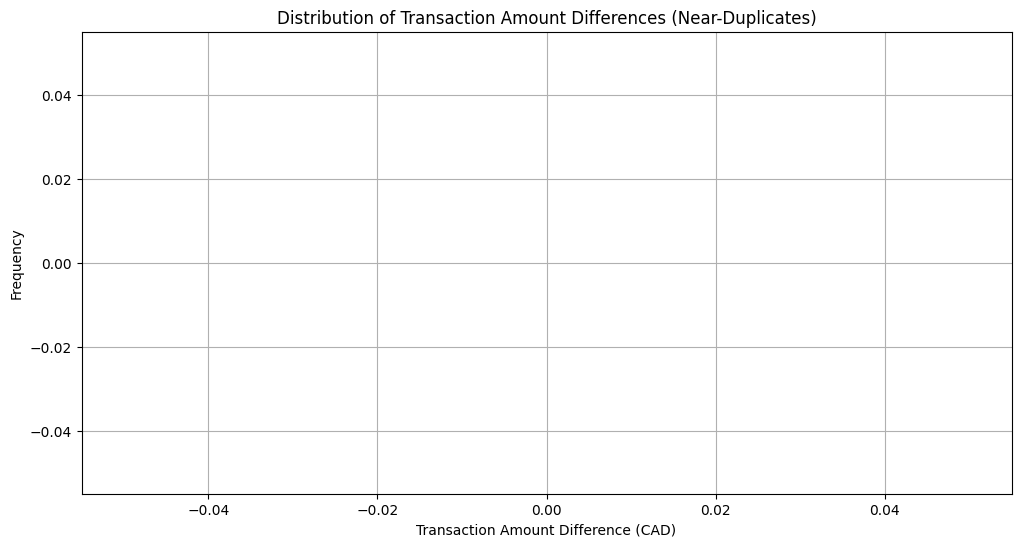

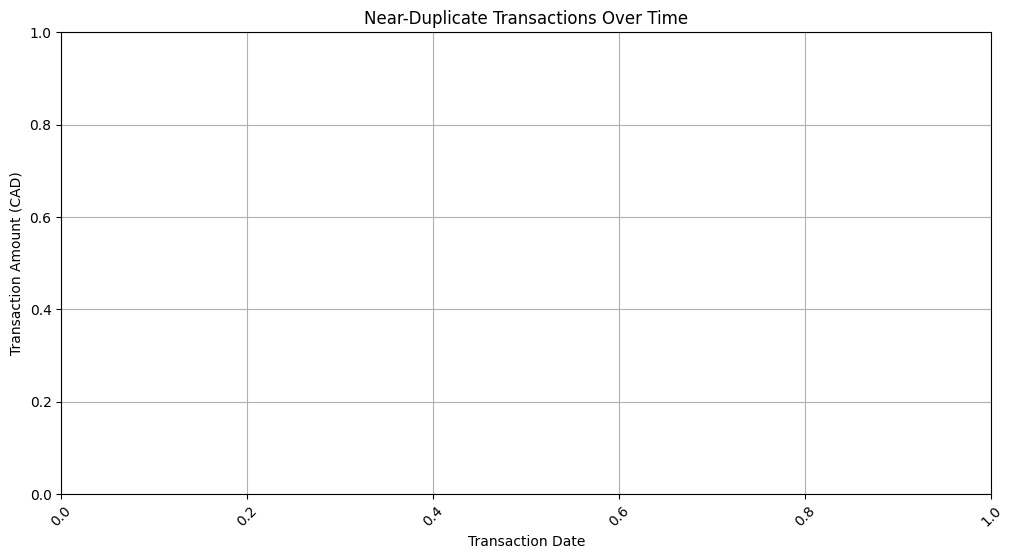

In [129]:
# Renaming the dataframe for clarity
cheque_df = df_sorted.copy()

# Identifying near-duplicate transactions (same customer, small amount variation, within 30 days)
amount_threshold = 0.05  # 5% variation allowed

cheque_df["prev_amount"] = cheque_df.groupby("customer_id")["amount_cad"].shift(1)
cheque_df["amount_diff"] = abs(cheque_df["amount_cad"] - cheque_df["prev_amount"])
cheque_df["relative_diff"] = cheque_df["amount_diff"] / cheque_df["prev_amount"]

# Filtering transactions where the relative difference is within 5% and within 30 days
near_duplicate_transactions = cheque_df[(cheque_df["time_diff"] <= 30) & (cheque_df["relative_diff"] <= amount_threshold)]

print("Near-Duplicate Fraud Transactions (30-Day Window, 5% Variation)")
print(near_duplicate_transactions.head())

# Visualizing the distribution of near-duplicate transactions
plt.figure(figsize=(12, 6))
sns.histplot(near_duplicate_transactions["amount_diff"], bins=50, kde=True)
plt.title("Distribution of Transaction Amount Differences (Near-Duplicates)")
plt.xlabel("Transaction Amount Difference (CAD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Scatter plot of near-duplicate transactions
plt.figure(figsize=(12, 6))
sns.scatterplot(x=near_duplicate_transactions["transaction_date"], y=near_duplicate_transactions["amount_cad"], alpha=0.5)
plt.title("Near-Duplicate Transactions Over Time")
plt.xlabel("Transaction Date")
plt.ylabel("Transaction Amount (CAD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


High-Activity Days (Potential Fraud Clusters)
                  count
transaction_date       
2023-01-03         1394


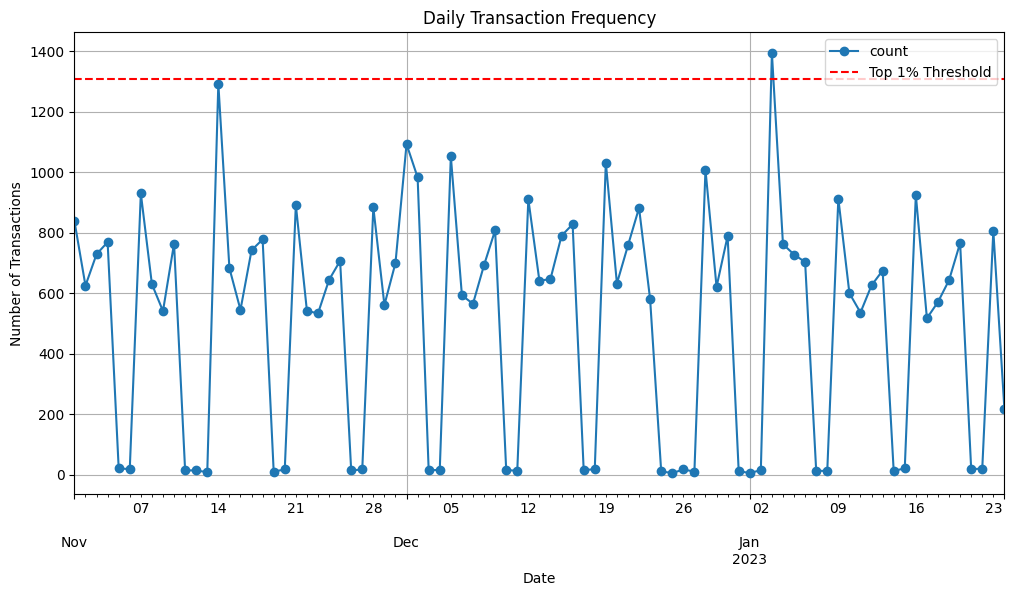

In [130]:
# Step 1: Identify High-Activity Days
transaction_counts_per_day = cheque_df["transaction_date"].value_counts().sort_index()

# Step 2: Identify Unusual Spikes (Top 1% highest activity days)
threshold = transaction_counts_per_day.quantile(0.99)  # Top 1% threshold
high_activity_days = transaction_counts_per_day[transaction_counts_per_day > threshold]

print("High-Activity Days (Potential Fraud Clusters)")
print(high_activity_days.to_frame())

# Step 4: Visualizing transaction frequency per day
plt.figure(figsize=(12, 6))
transaction_counts_per_day.plot(kind="line", marker="o")
plt.axhline(y=threshold, color='r', linestyle='--', label="Top 1% Threshold")
plt.title("Daily Transaction Frequency")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.grid(True)
plt.show()

Customer Clusters Based on Spending Behavior
        customer_id  total_spent    avg_spent  transaction_count  cluster
0  SYNCID0000000016        17.19    17.190000                  1        0
1  SYNCID0000000017     17520.07  8760.035000                  2        0
2  SYNCID0000000019     97907.76  1659.453559                 59        0
3  SYNCID0000000034      4358.33  2179.165000                  2        0
4  SYNCID0000000035      9665.12  3221.706667                  3        0


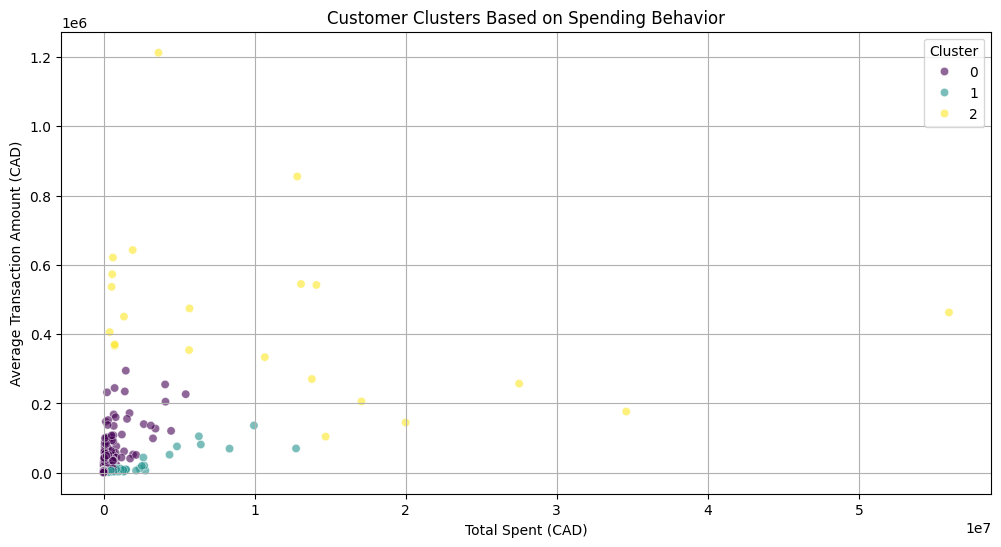

In [131]:
# Step 5: Cluster Customers Based on Spending Behavior
from sklearn.cluster import KMeans
import numpy as np

# Selecting relevant features for clustering
customer_spending = cheque_df.groupby("customer_id")["amount_cad"].agg(["sum", "mean", "count"]).reset_index()
customer_spending.columns = ["customer_id", "total_spent", "avg_spent", "transaction_count"]

# Standardizing data for clustering
customer_spending_scaled = customer_spending[["total_spent", "avg_spent", "transaction_count"]].apply(lambda x: (x - x.mean()) / x.std())

# Applying K-Means Clustering (Choosing 3 clusters for simplicity)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_spending["cluster"] = kmeans.fit_predict(customer_spending_scaled)

print("Customer Clusters Based on Spending Behavior")
print(customer_spending.head())

# Step 7: Visualizing Clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=customer_spending["total_spent"], y=customer_spending["avg_spent"], hue=customer_spending["cluster"], palette="viridis", alpha=0.6)
plt.title("Customer Clusters Based on Spending Behavior")
plt.xlabel("Total Spent (CAD)")
plt.ylabel("Average Transaction Amount (CAD)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

Transaction Volume by Day of the Week:
{'Friday': 5756, 'Monday': 5180, 'Saturday': 3971, 'Sunday': 3143, 'Thursday': 5919, 'Tuesday': 6095, 'Wednesday': 5568}

Transaction Volume by Day of the Month:
{1: 1363, 2: 1276, 3: 1177, 4: 1180, 5: 1188, 6: 1091, 7: 1162, 8: 1165, 9: 1283, 10: 1263, 11: 1064, 12: 1052, 13: 1176, 14: 1168, 15: 1063, 16: 1338, 17: 1146, 18: 1158, 19: 1196, 20: 1238, 21: 1162, 22: 1258, 23: 1187, 24: 1152, 25: 953, 26: 1031, 27: 1005, 28: 1181, 29: 1083, 30: 1131, 31: 742}


<ipython-input-132-be464ec634c4>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(day_of_week_counts.keys()), y=list(day_of_week_counts.values()), palette="Blues_r")


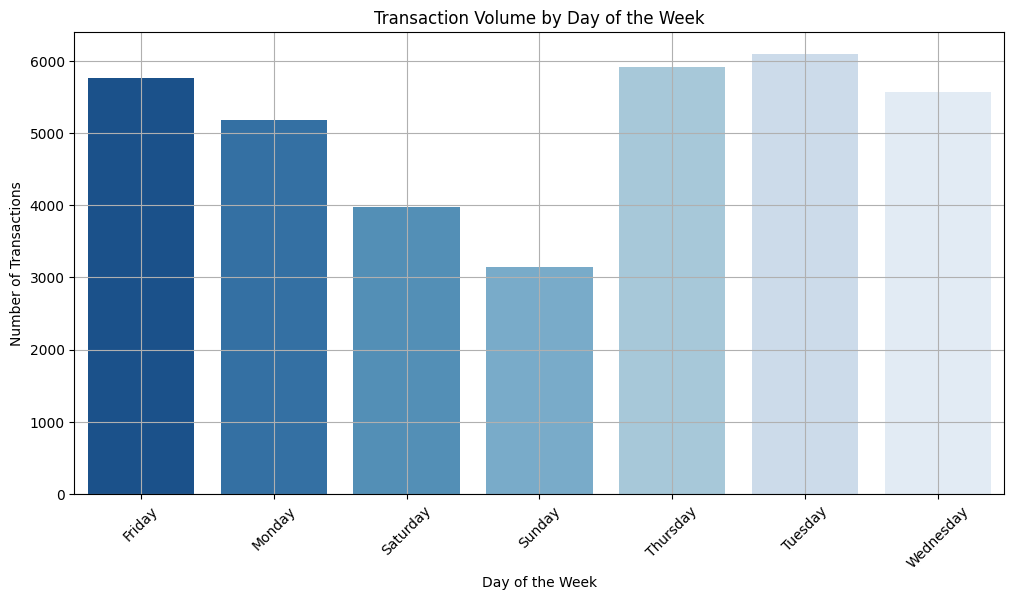

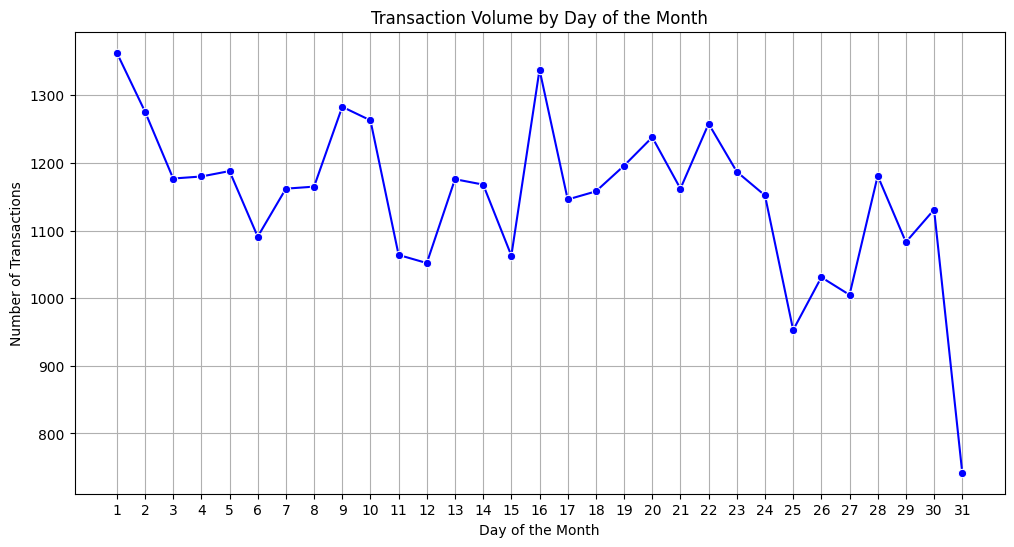

In [132]:
# Reload the dataset in chunks for memory efficiency
chunk_size = 10000  # Process 10,000 rows at a time
day_of_week_counts = {}
day_of_month_counts = {}

# Process dataset in chunks
for chunk in pd.read_csv(file_path, usecols=["transaction_date"], chunksize=chunk_size, parse_dates=["transaction_date"]):
    # Extract Day of the Week and Day of the Month
    chunk["day_of_week"] = chunk["transaction_date"].dt.day_name()
    chunk["day_of_month"] = chunk["transaction_date"].dt.day

    # Aggregate day of the week counts
    for day in chunk["day_of_week"].value_counts().index:
        day_of_week_counts[day] = day_of_week_counts.get(day, 0) + chunk["day_of_week"].value_counts()[day]

    # Aggregate day of the month counts
    for day in chunk["day_of_month"].value_counts().index:
        day_of_month_counts[day] = day_of_month_counts.get(day, 0) + chunk["day_of_month"].value_counts()[day]

# Convert dictionaries to sorted lists
day_of_week_counts = dict(sorted(day_of_week_counts.items()))
day_of_month_counts = dict(sorted(day_of_month_counts.items()))

# Display Transaction Patterns
print("Transaction Volume by Day of the Week:")
print(day_of_week_counts)

print("\nTransaction Volume by Day of the Month:")
print(day_of_month_counts)

# Visualizing Transaction Patterns by Day of the Week
plt.figure(figsize=(12, 6))
sns.barplot(x=list(day_of_week_counts.keys()), y=list(day_of_week_counts.values()), palette="Blues_r")
plt.title("Transaction Volume by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualizing Transaction Patterns by Day of the Month
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(day_of_month_counts.keys()), y=list(day_of_month_counts.values()), marker="o", color="b")
plt.title("Transaction Volume by Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Number of Transactions")
plt.xticks(range(1, 32))
plt.grid(True)
plt.show()

High-Risk Transactions by Day of the Week:
day_of_week
Monday       504
Thursday     477
Friday       396
Wednesday    384
Tuesday      379
Sunday         6
Saturday       5
Name: count, dtype: int64

High-Risk Transactions by Day of the Month:
day_of_month
1      97
2      76
3     108
4      63
5      87
6      58
7      79
8      59
9     106
10     78
11     21
12     76
13     63
14    105
15     71
16    119
17     65
18     78
19     84
20     53
21     70
22     70
23    100
24     48
25     36
26      1
27      3
28    110
29     77
30     88
31      2
Name: count, dtype: int64

Top Industries in High-Risk Transactions by Day of the Week:
    day_of_week                   industry  amount_cad
555   Wednesday             Direct Sellers          20
303    Thursday  Garages (General Repairs)          14
288    Thursday             Direct Sellers          14
142      Monday             Direct Sellers          13
180      Monday               Masonry Work          12

Top Customers

<ipython-input-133-ebdea3c4cee9>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_by_week.index, y=high_risk_by_week.values, palette="Reds_r")


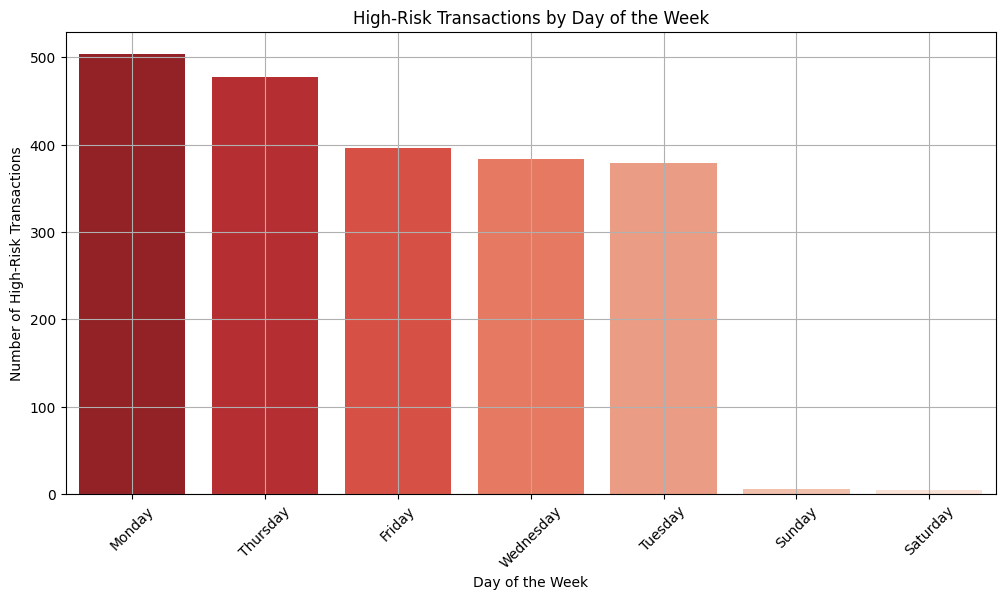

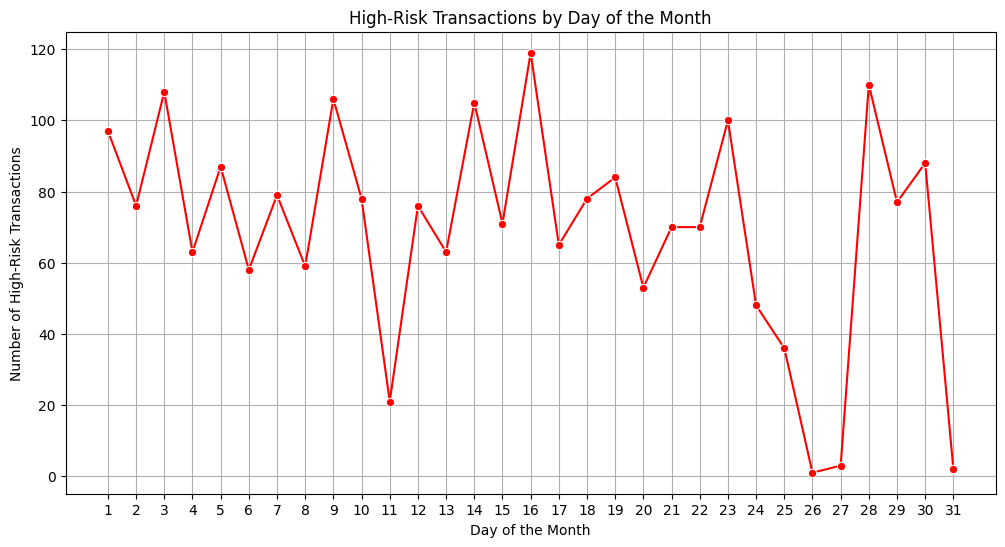

In [133]:
# Extract Day of the Week and Day of the Month
cheque_df["day_of_week"] = cheque_df["transaction_date"].dt.day_name()
cheque_df["day_of_month"] = cheque_df["transaction_date"].dt.day

# Step 1: Correlation Between High-Risk Transactions and Peak Days
# Define high-risk transactions as those in the top 5% of amount_cad
high_risk_threshold = cheque_df["amount_cad"].quantile(0.95)
high_risk_transactions = cheque_df[cheque_df["amount_cad"] >= high_risk_threshold]

# Count high-risk transactions per day of the week & month
high_risk_by_week = high_risk_transactions["day_of_week"].value_counts()
high_risk_by_month = high_risk_transactions["day_of_month"].value_counts().sort_index()

# Step 2: Identifying Dominant Customers or Industries on Peak Days
# Group by industry and day of the week for high-risk transactions
high_risk_industries = high_risk_transactions.groupby(["day_of_week", "industry"])["amount_cad"].count().reset_index()
high_risk_industries = high_risk_industries.sort_values(by="amount_cad", ascending=False)

# Group by customer and day of the week for high-risk transactions
high_risk_customers = high_risk_transactions.groupby(["day_of_week", "customer_id"])["amount_cad"].count().reset_index()
high_risk_customers = high_risk_customers.sort_values(by="amount_cad", ascending=False)

# Step 3: Checking if Fraud-Prone Customers Transact on Specific Days
# Identify customers who frequently appear in high-risk transactions
fraud_prone_customers = high_risk_transactions["customer_id"].value_counts()
top_fraud_customers = fraud_prone_customers[fraud_prone_customers > fraud_prone_customers.quantile(0.95)]

# Get transaction patterns for these fraud-prone customers
fraud_customers_data = cheque_df[cheque_df["customer_id"].isin(top_fraud_customers.index)]
fraud_by_week = fraud_customers_data["day_of_week"].value_counts()
fraud_by_month = fraud_customers_data["day_of_month"].value_counts().sort_index()

# Display findings
print("High-Risk Transactions by Day of the Week:")
print(high_risk_by_week)

print("\nHigh-Risk Transactions by Day of the Month:")
print(high_risk_by_month)

print("\nTop Industries in High-Risk Transactions by Day of the Week:")
print(high_risk_industries.head())

print("\nTop Customers in High-Risk Transactions by Day of the Week:")
print(high_risk_customers.head())

print("\nFraud-Prone Customers' Transaction Patterns by Day of the Week:")
print(fraud_by_week)

print("\nFraud-Prone Customers' Transaction Patterns by Day of the Month:")
print(fraud_by_month)

# Visualizing High-Risk Transactions Over Time
plt.figure(figsize=(12, 6))
sns.barplot(x=high_risk_by_week.index, y=high_risk_by_week.values, palette="Reds_r")
plt.title("High-Risk Transactions by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of High-Risk Transactions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=high_risk_by_month.index, y=high_risk_by_month.values, marker="o", color="r")
plt.title("High-Risk Transactions by Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Number of High-Risk Transactions")
plt.xticks(range(1, 32))
plt.grid(True)
plt.show()

Top Fraud-Prone Industries & High-Risk Customers:
                                            industry       customer_id  \
128                                   Direct Sellers  SYNCID0000008227   
285                                     Golf Courses  SYNCID0000011994   
523  Other Machinery and Equipment Industries n.e.c.  SYNCID0000000596   
232                            Gas and Oil Pipelines  SYNCID0000000844   
341                                     Masonry Work  SYNCID0000003476   

     amount_cad  
128          38  
285          26  
523          26  
232          25  
341          21  

Cities with the Most High-Risk Transactions:
            city  amount_cad
184        other         660
165      TORONTO         163
22       CALGARY          67
78       MARKHAM          56
86   MISSISSAUGA          44

Recurring Transactions Among High-Risk Customers:
                  cheque_id       customer_id  amount_cad debit_credit  \
7751   CHE00000000000000831  SYNCID0000000047      5

<ipython-input-134-0f2176511d48>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_industry_customer["industry"][:10], y=fraud_industry_customer["amount_cad"][:10], palette="Reds_r")


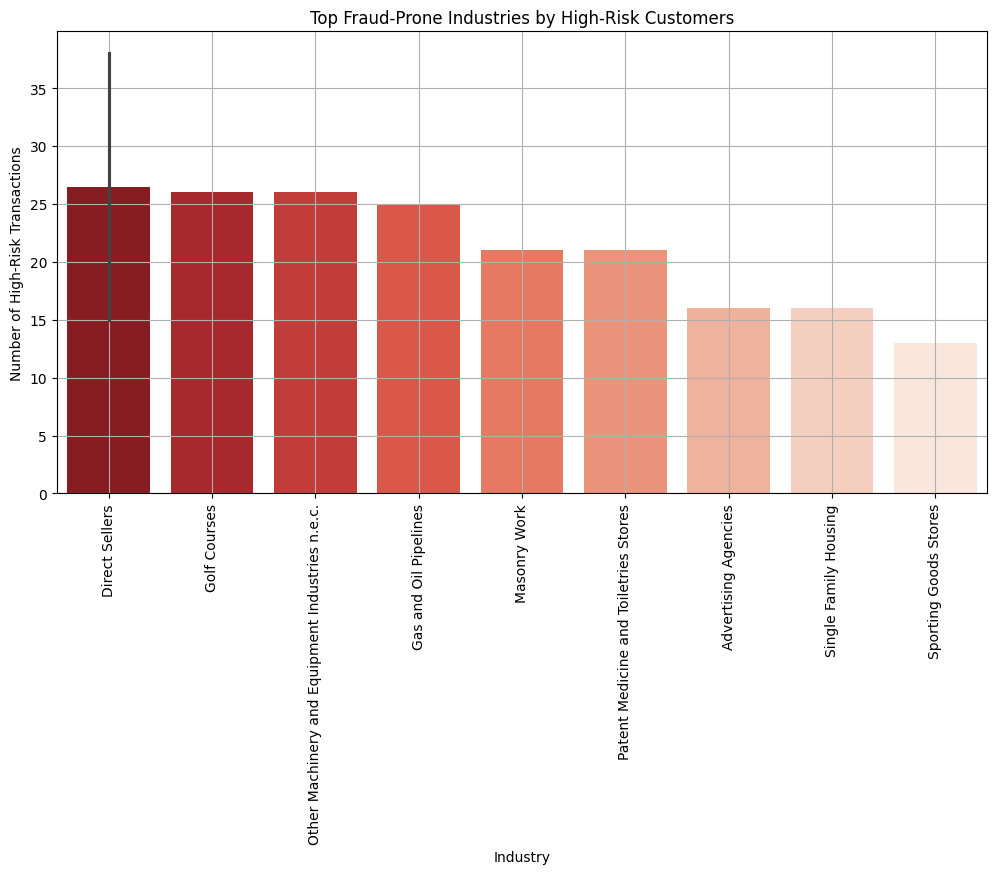

<ipython-input-134-0f2176511d48>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_city["city"][:10], y=fraud_by_city["amount_cad"][:10], palette="Blues_r")


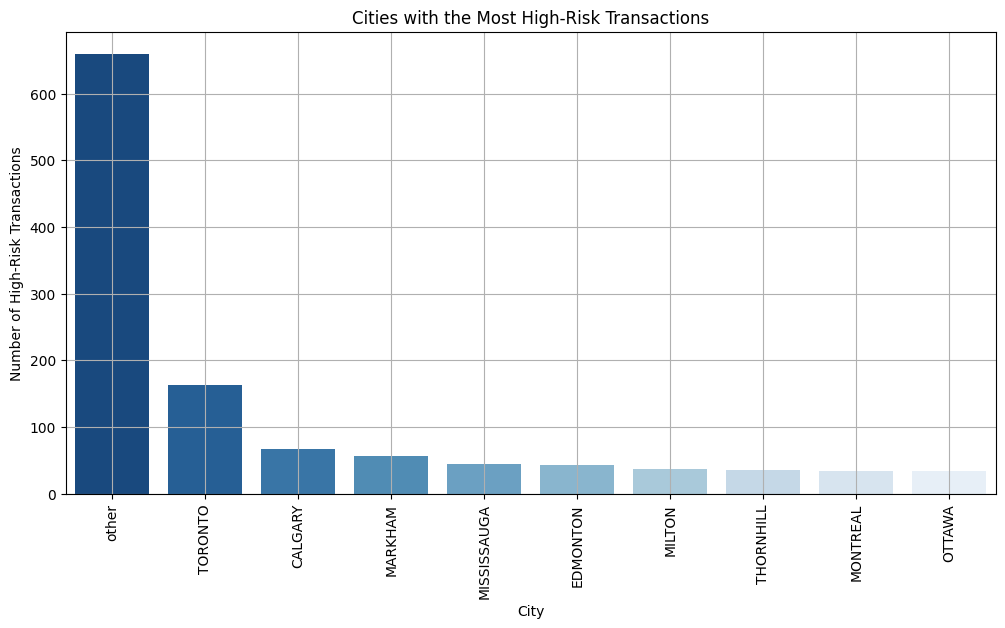

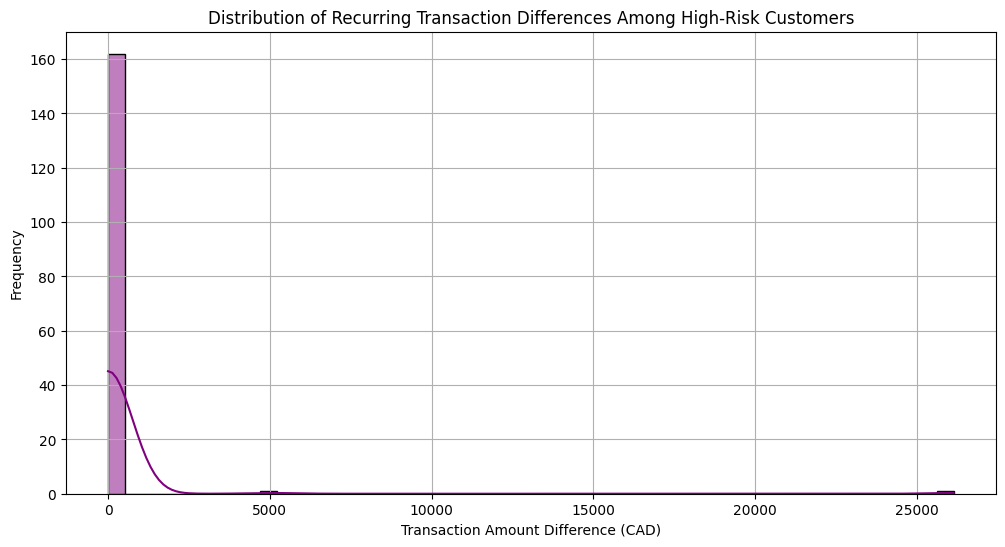

In [134]:
# Step 1: Investigate Correlations Between Fraud-Prone Industries & High-Risk Customers
fraud_industry_customer = high_risk_transactions.groupby(["industry", "customer_id"])["amount_cad"].count().reset_index()
fraud_industry_customer = fraud_industry_customer.sort_values(by="amount_cad", ascending=False)

# Extract high-risk transactions again
high_risk_transactions = cheque_df[cheque_df["amount_cad"] >= high_risk_threshold]

# Group high-risk transactions by city
fraud_by_city = high_risk_transactions.groupby("city")["amount_cad"].count().reset_index()
fraud_by_city = fraud_by_city.sort_values(by="amount_cad", ascending=False)

# Step 3: Detect Recurring Transaction Patterns Among High-Risk Customers
# Identify customers with repeated transactions of the same amount
cheque_df["prev_amount"] = cheque_df.groupby("customer_id")["amount_cad"].shift(1)
cheque_df["amount_diff"] = abs(cheque_df["amount_cad"] - cheque_df["prev_amount"])

# Define threshold for recurring transactions (small differences in amounts)
recurring_transactions = cheque_df[cheque_df["amount_diff"] < cheque_df["amount_cad"] * 0.01]  # 1% variation

# Display findings
print("Top Fraud-Prone Industries & High-Risk Customers:")
print(fraud_industry_customer.head())

print("\nCities with the Most High-Risk Transactions:")
print(fraud_by_city.head())

print("\nRecurring Transactions Among High-Risk Customers:")
print(recurring_transactions.head())

# Step 4: Visualizing Fraud-Prone Industries & High-Risk Customers
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_industry_customer["industry"][:10], y=fraud_industry_customer["amount_cad"][:10], palette="Reds_r")
plt.title("Top Fraud-Prone Industries by High-Risk Customers")
plt.xlabel("Industry")
plt.ylabel("Number of High-Risk Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 5: Visualizing Fraud Concentration by City
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_city["city"][:10], y=fraud_by_city["amount_cad"][:10], palette="Blues_r")
plt.title("Cities with the Most High-Risk Transactions")
plt.xlabel("City")
plt.ylabel("Number of High-Risk Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 6: Visualizing Recurring Transactions Among High-Risk Customers
plt.figure(figsize=(12, 6))
sns.histplot(recurring_transactions["amount_diff"], bins=50, kde=True, color="purple")
plt.title("Distribution of Recurring Transaction Differences Among High-Risk Customers")
plt.xlabel("Transaction Amount Difference (CAD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [135]:
# Step 1: Analyze if Recurring Transactions Happen on Specific Days of the Week
recurring_transactions["day_of_week"] = recurring_transactions["transaction_date"].dt.day_name()
recurring_by_week = recurring_transactions["day_of_week"].value_counts()

# Step 2: Cross-Check Flagged Customers with Business Legitimacy (Employee Count & Sales)
# Reload dataset with necessary columns

# Merge high-risk customers with business details
high_risk_customers_legitimacy = cheque_df[cheque_df["customer_id"].isin(top_fraud_customers.index)].groupby("customer_id").agg({
    "amount_cad": "sum",
    "employee_count": "mean",
    "sales": "mean"
}).reset_index()

# Identify customers with high spending but low business legitimacy
suspicious_businesses = high_risk_customers_legitimacy[(high_risk_customers_legitimacy["employee_count"] < 2) & (high_risk_customers_legitimacy["sales"] < high_risk_customers_legitimacy["amount_cad"] * 0.1)]

<ipython-input-135-68b4f93d4653>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurring_transactions["day_of_week"] = recurring_transactions["transaction_date"].dt.day_name()


<ipython-input-136-f34e9cacad82>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recurring_by_week.index, y=recurring_by_week.values, palette="Purples_r")


Recurring Transactions by Day of the Week:
day_of_week
Monday       41
Friday       38
Thursday     32
Wednesday    29
Tuesday      24
Name: count, dtype: int64

High-Risk Customers with Suspicious Business Legitimacy:
         customer_id   amount_cad  employee_count     sales
5   SYNCID0000000904   2375371.36             0.0       0.0
10  SYNCID0000002937    596515.56             1.0       0.0
16  SYNCID0000005296  27511500.79             1.0  238260.0
18  SYNCID0000006350    984170.91             1.0   33088.0
21  SYNCID0000008227  34602544.92             1.0  181531.0
25  SYNCID0000008509  55969121.17             1.0  239195.0
29  SYNCID0000010065    950033.53             1.0       0.0
30  SYNCID0000010375    576204.48             0.0       0.0
38  SYNCID0000013148   2154942.41             0.0       0.0
40  SYNCID0000015328   2637326.10             1.0  234298.0
41  SYNCID0000015964    899420.58             1.0       0.0

Fraud Patterns by Business Category (Wholesale vs. Retail):


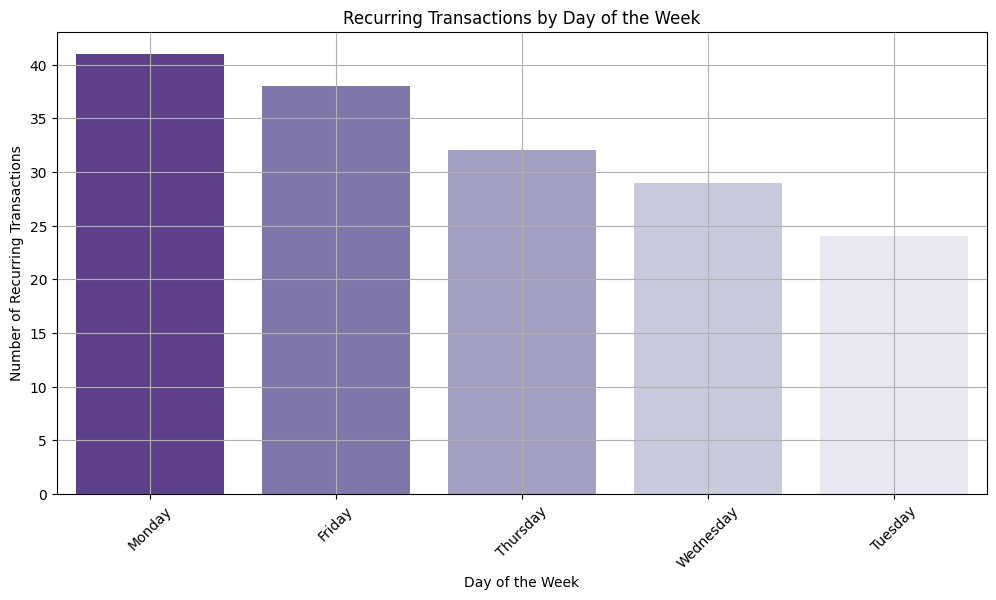

<ipython-input-136-f34e9cacad82>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_industry.index[:10], y=fraud_by_industry["count"][:10], palette="Oranges_r")


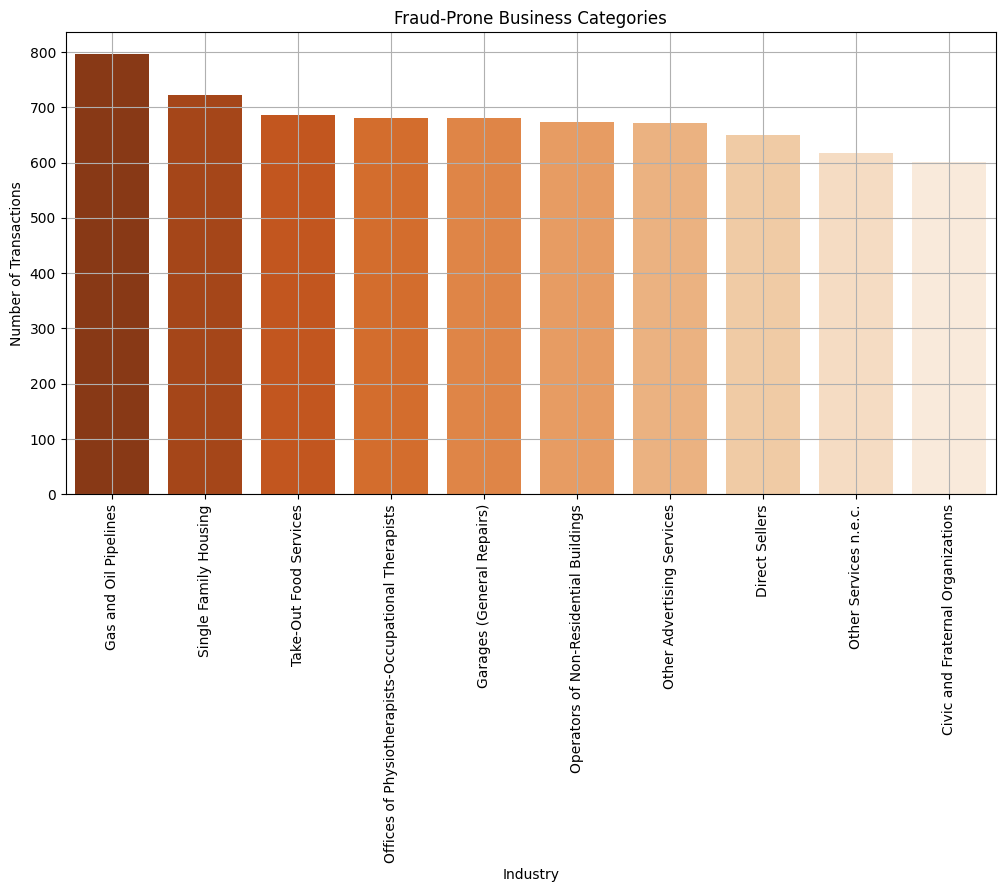

In [136]:
# Step 3: Analyze Fraud Patterns in Different Business Categories (Wholesale vs. Retail)

# Group transactions by industry type
fraud_by_industry = cheque_df.groupby("industry")["amount_cad"].agg(["count", "mean", "max"]).sort_values(by="count", ascending=False)

# Display Findings
print("Recurring Transactions by Day of the Week:")
print(recurring_by_week)

print("\nHigh-Risk Customers with Suspicious Business Legitimacy:")
print(suspicious_businesses)

print("\nFraud Patterns by Business Category (Wholesale vs. Retail):")
print(fraud_by_industry.head())

# Step 4: Visualizing Recurring Transactions by Day of the Week
plt.figure(figsize=(12, 6))
sns.barplot(x=recurring_by_week.index, y=recurring_by_week.values, palette="Purples_r")
plt.title("Recurring Transactions by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Recurring Transactions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Step 5: Visualizing Fraud Patterns in Different Business Categories
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_by_industry.index[:10], y=fraud_by_industry["count"][:10], palette="Oranges_r")
plt.title("Fraud-Prone Business Categories")
plt.xlabel("Industry")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

High-Risk Customers & Their Associated Industries:
        customer_id                                industry   amount_cad
4  SYNCID0000008227                          Direct Sellers  34602544.92
2  SYNCID0000005296   Patent Medicine and Toiletries Stores  27511500.79
8  SYNCID0000015328        Other Waste Materials, Wholesale   2637326.10
0  SYNCID0000000904                    Advertising Agencies   2375371.36
7  SYNCID0000013148  Operators of Non-Residential Buildings   2154942.41

Geographic Clusters of Suspicious Customers:
            city province   amount_cad
7        SUDBURY       ON  55969121.17
2        MARKHAM       ON  34602544.92
3         MILTON       ON  27511500.79
5  SHERWOOD PARK       AB   2637326.10
1      DARTMOUTH       NS    984170.91

Industries Where Transactions Far Exceed Reported Sales (Potential Fraud):
                                            industry  amount_cad  \
0                               Advertising Agencies  3665827.05   
8   Automobile and 

<ipython-input-137-972985fd9c74>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_customer_industry["industry"][:10], y=high_risk_customer_industry["amount_cad"][:10], palette="Reds_r")


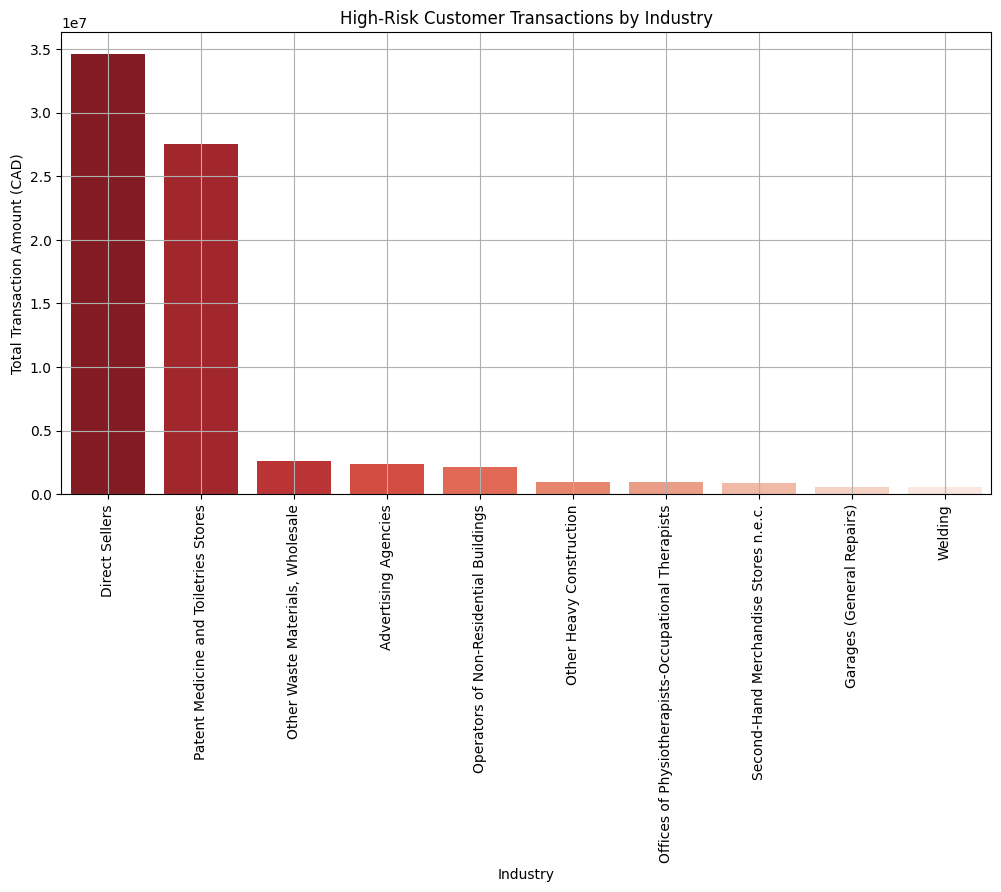

<ipython-input-137-972985fd9c74>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suspicious_customers_by_location["city"][:10], y=suspicious_customers_by_location["amount_cad"][:10], palette="Blues_r")


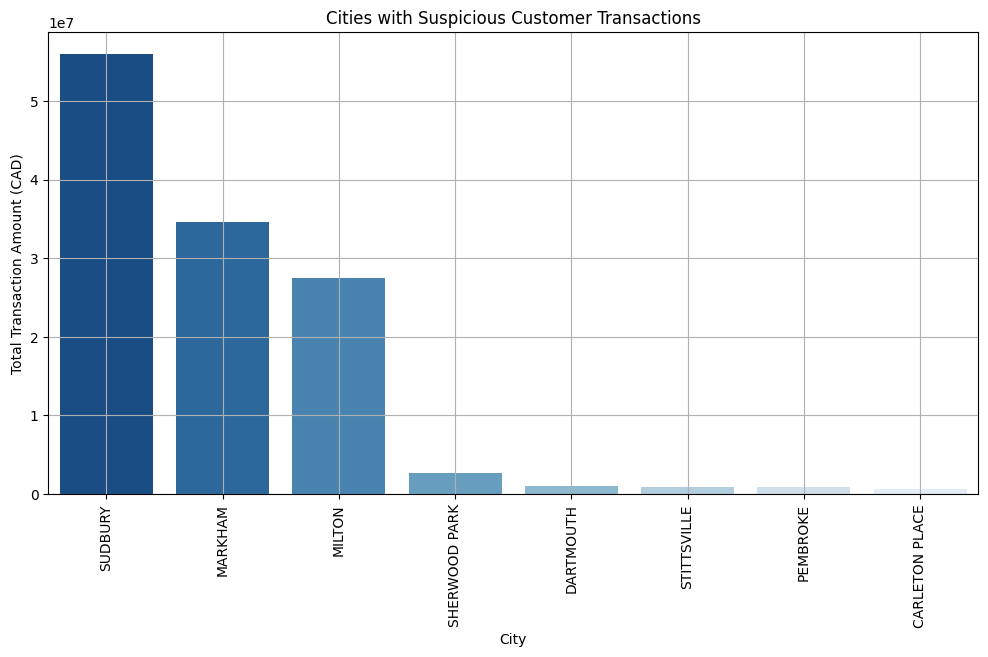

<ipython-input-137-972985fd9c74>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_sales_anomalies["industry"][:10], y=industry_sales_anomalies["amount_cad"][:10], palette="Oranges_r")


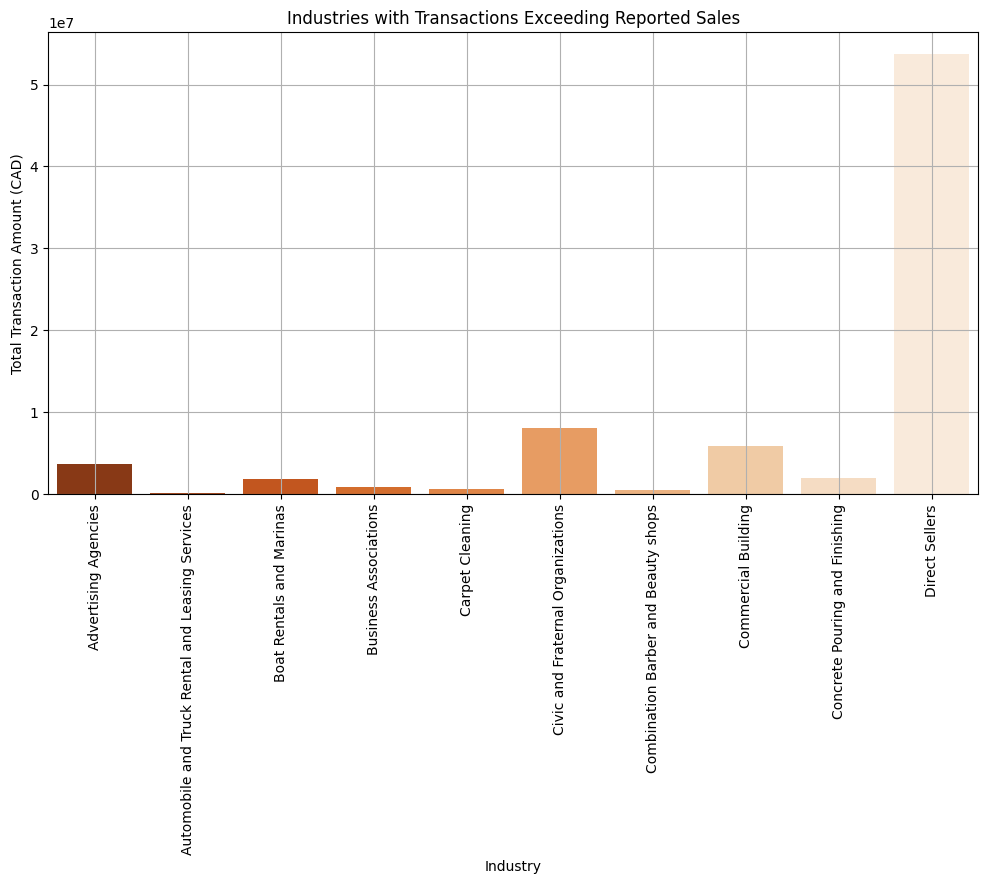

In [137]:
# Step 1: Investigate Links Between High-Risk Customers & Fraud-Prone Industries
high_risk_customer_industry = cheque_df[cheque_df["customer_id"].isin(suspicious_businesses["customer_id"])].groupby(["customer_id", "industry"])["amount_cad"].sum().reset_index()
high_risk_customer_industry = high_risk_customer_industry.sort_values(by="amount_cad", ascending=False)

# Step 2: Identify Geographic Clusters of Customers with Suspicious Business Legitimacy
suspicious_customers_location = cheque_df[cheque_df["customer_id"].isin(suspicious_businesses["customer_id"])]

# Group by location (city/province)
suspicious_customers_by_location = suspicious_customers_location.groupby(["city", "province"])["amount_cad"].sum().reset_index()
suspicious_customers_by_location = suspicious_customers_by_location.sort_values(by="amount_cad", ascending=False)

# Step 3: Cross-Check Flagged Transactions Against Industry Sales Trends for Anomalies
# Compare industry average sales with total transaction amounts
industry_sales_comparison = cheque_df.groupby("industry").agg({
    "amount_cad": "sum",
    "sales": "mean"
}).reset_index()

# Identify industries where total transaction amounts far exceed reported sales (potential fraud)
industry_sales_anomalies = industry_sales_comparison[industry_sales_comparison["amount_cad"] > (industry_sales_comparison["sales"] * 10)]

# Display findings
print("High-Risk Customers & Their Associated Industries:")
print(high_risk_customer_industry.head())

print("\nGeographic Clusters of Suspicious Customers:")
print(suspicious_customers_by_location.head())

print("\nIndustries Where Transactions Far Exceed Reported Sales (Potential Fraud):")
print(industry_sales_anomalies.head())

# Step 4: Visualizing High-Risk Customer Transactions by Industry
plt.figure(figsize=(12, 6))
sns.barplot(x=high_risk_customer_industry["industry"][:10], y=high_risk_customer_industry["amount_cad"][:10], palette="Reds_r")
plt.title("High-Risk Customer Transactions by Industry")
plt.xlabel("Industry")
plt.ylabel("Total Transaction Amount (CAD)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 5: Visualizing Geographic Clusters of Suspicious Customers
plt.figure(figsize=(12, 6))
sns.barplot(x=suspicious_customers_by_location["city"][:10], y=suspicious_customers_by_location["amount_cad"][:10], palette="Blues_r")
plt.title("Cities with Suspicious Customer Transactions")
plt.xlabel("City")
plt.ylabel("Total Transaction Amount (CAD)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 6: Visualizing Industry Sales vs. Transaction Anomalies
plt.figure(figsize=(12, 6))
sns.barplot(x=industry_sales_anomalies["industry"][:10], y=industry_sales_anomalies["amount_cad"][:10], palette="Oranges_r")
plt.title("Industries with Transactions Exceeding Reported Sales")
plt.xlabel("Industry")
plt.ylabel("Total Transaction Amount (CAD)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

High-Risk Customers with Frequent Transactions:
        customer_id  amount_cad
4  SYNCID0000008227         196
0  SYNCID0000000904         194
3  SYNCID0000006350         193
7  SYNCID0000010375         168
6  SYNCID0000010065         164

Fraud-Prone Locations & Their Most Common Industries:
             city                               industry   amount_cad
17        MARKHAM                         Direct Sellers  34602544.92
32         MILTON  Patent Medicine and Toiletries Stores  27511500.79
48  SHERWOOD PARK       Other Waste Materials, Wholesale   2637326.10
34         MILTON            Rough and Framing Carpentry   1004684.06
10      DARTMOUTH               Other Heavy Construction    984170.91

Links Between Flagged Industries & Flagged Customers:
        customer_id                                industry   amount_cad
4  SYNCID0000008227                          Direct Sellers  34602544.92
2  SYNCID0000005296   Patent Medicine and Toiletries Stores  27511500.79
8  SYNCID00

<ipython-input-138-e0f911b6a5da>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_customer_transactions["customer_id"][:10], y=high_risk_customer_transactions["amount_cad"][:10], palette="Reds_r")


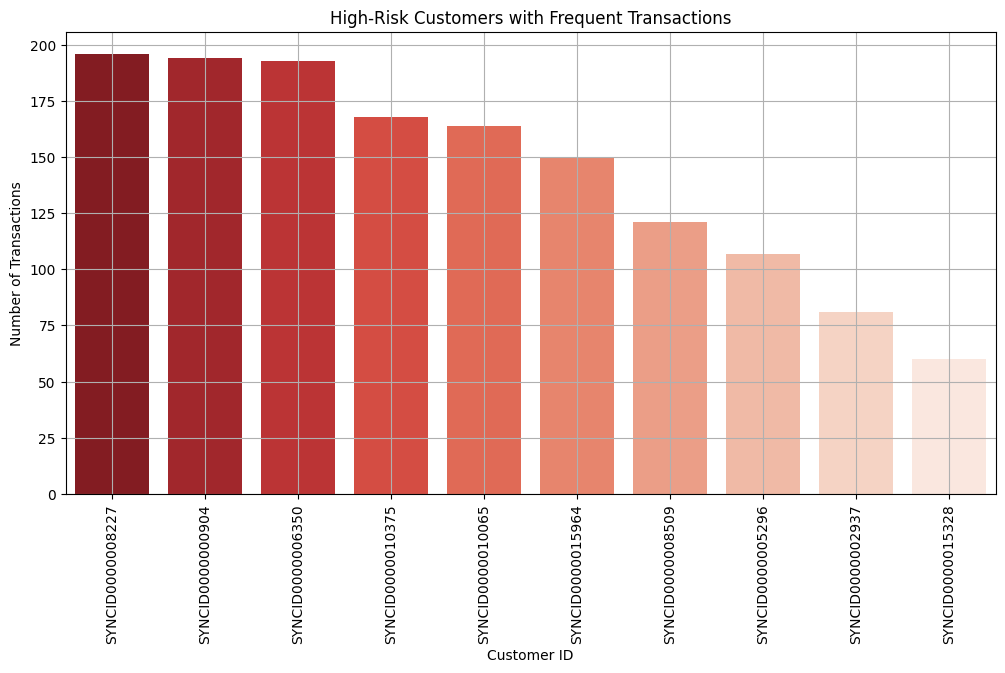

<ipython-input-138-e0f911b6a5da>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_industries_by_city["city"][:10], y=fraud_industries_by_city["amount_cad"][:10], palette="Blues_r")


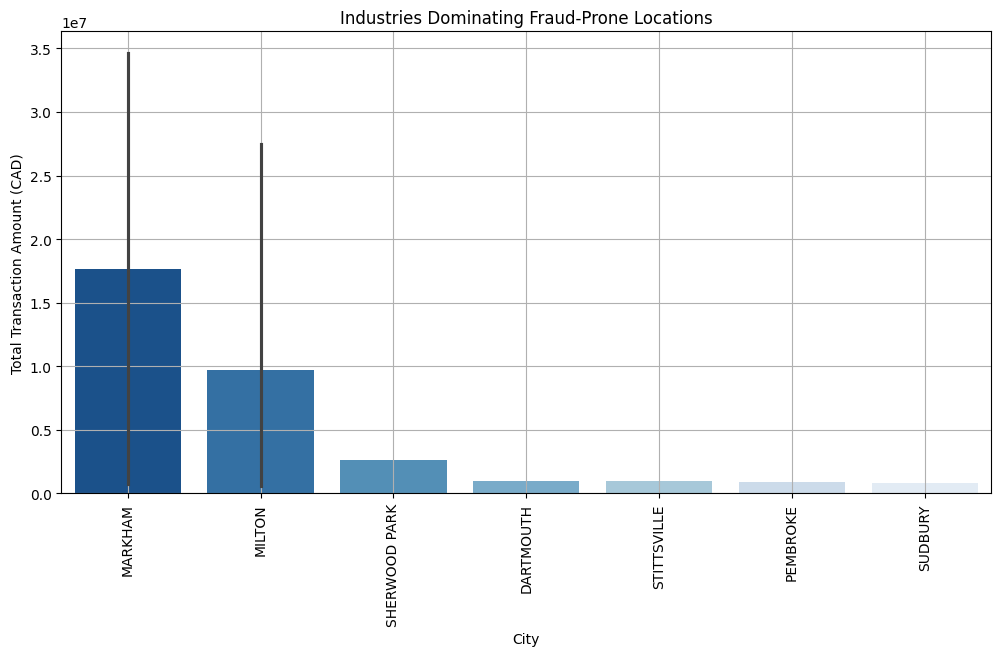

<ipython-input-138-e0f911b6a5da>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_industry_links["industry"][:10], y=customer_industry_links["amount_cad"][:10], palette="Oranges_r")


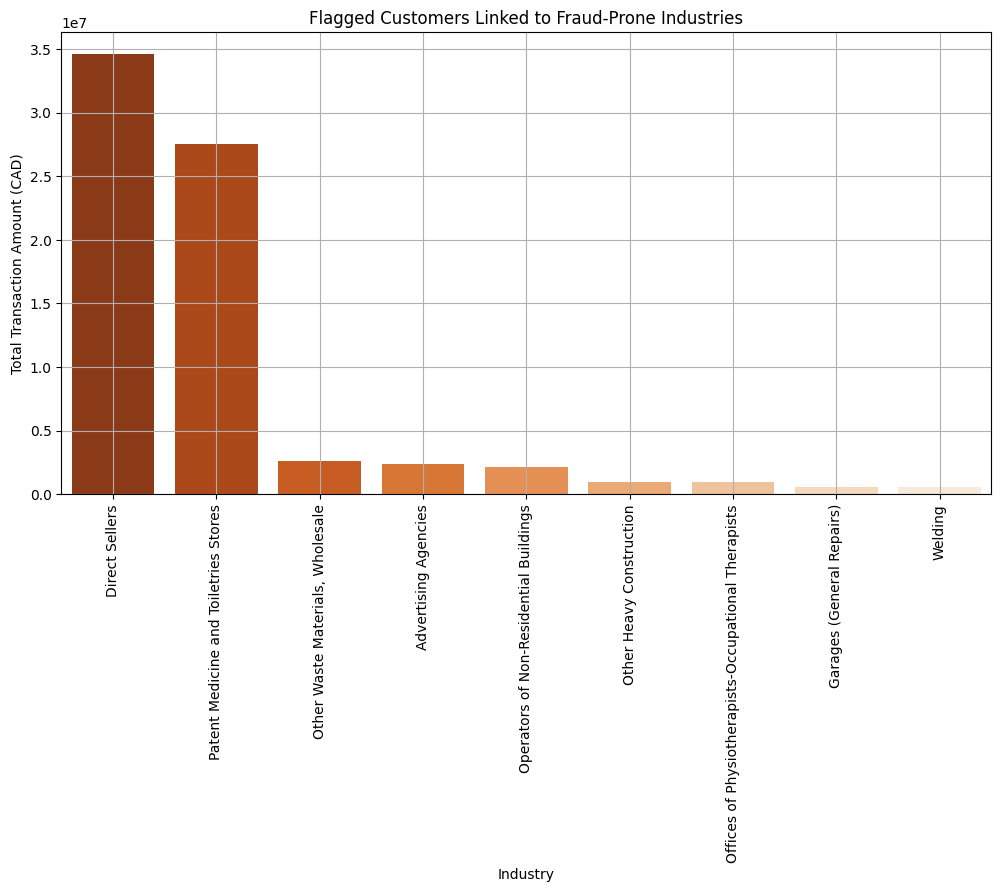

In [138]:
# Step 1: Cross-Check High-Risk Customers with Transaction Frequency
high_risk_customer_transactions = cheque_df[cheque_df["customer_id"].isin(suspicious_businesses["customer_id"])].groupby("customer_id")["amount_cad"].count().reset_index()
high_risk_customer_transactions = high_risk_customer_transactions.sort_values(by="amount_cad", ascending=False)

# Step 2: Analyze Whether Fraud-Prone Locations Have Specific Industries Dominating Transactions
fraud_industries_by_city = cheque_df[cheque_df["city"].isin(suspicious_customers_by_location["city"][:10])].groupby(["city", "industry"])["amount_cad"].sum().reset_index()
fraud_industries_by_city = fraud_industries_by_city.sort_values(by="amount_cad", ascending=False)

# Step 3: Investigate Links Between Flagged Industries and Flagged Customers
customer_industry_links = cheque_df[cheque_df["customer_id"].isin(suspicious_businesses["customer_id"]) & cheque_df["industry"].isin(industry_sales_anomalies["industry"])].groupby(["customer_id", "industry"])["amount_cad"].sum().reset_index()
customer_industry_links = customer_industry_links.sort_values(by="amount_cad", ascending=False)

# Display Findings
print("High-Risk Customers with Frequent Transactions:")
print(high_risk_customer_transactions.head())

print("\nFraud-Prone Locations & Their Most Common Industries:")
print(fraud_industries_by_city.head())

print("\nLinks Between Flagged Industries & Flagged Customers:")
print(customer_industry_links.head())

# Step 4: Visualizing Transaction Frequency Among High-Risk Customers
plt.figure(figsize=(12, 6))
sns.barplot(x=high_risk_customer_transactions["customer_id"][:10], y=high_risk_customer_transactions["amount_cad"][:10], palette="Reds_r")
plt.title("High-Risk Customers with Frequent Transactions")
plt.xlabel("Customer ID")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 5: Visualizing Industries Dominating Fraud-Prone Locations
plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_industries_by_city["city"][:10], y=fraud_industries_by_city["amount_cad"][:10], palette="Blues_r")
plt.title("Industries Dominating Fraud-Prone Locations")
plt.xlabel("City")
plt.ylabel("Total Transaction Amount (CAD)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 6: Visualizing Links Between Flagged Customers & Industries
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_industry_links["industry"][:10], y=customer_industry_links["amount_cad"][:10], palette="Oranges_r")
plt.title("Flagged Customers Linked to Fraud-Prone Industries")
plt.xlabel("Industry")
plt.ylabel("Total Transaction Amount (CAD)")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Common Transaction Amounts Among High-Risk Customers:
     amount_cad  transaction_count
944     2071.49                  2
206      229.31                  2
102      107.84                  2
537      749.94                  2
980     2364.86                  1

Customers with Frequent Transactions of the Same Amount:
          customer_id  amount_cad  frequency
0    SYNCID0000000904        9.80          1
981  SYNCID0000010065     1614.60          1
990  SYNCID0000010065     1876.07          1
989  SYNCID0000010065     1819.42          1
988  SYNCID0000010065     1727.67          1

Flagged Transactions Categorized by Payment Method:
  debit_credit    amount_cad
0        debit  1.292572e+08


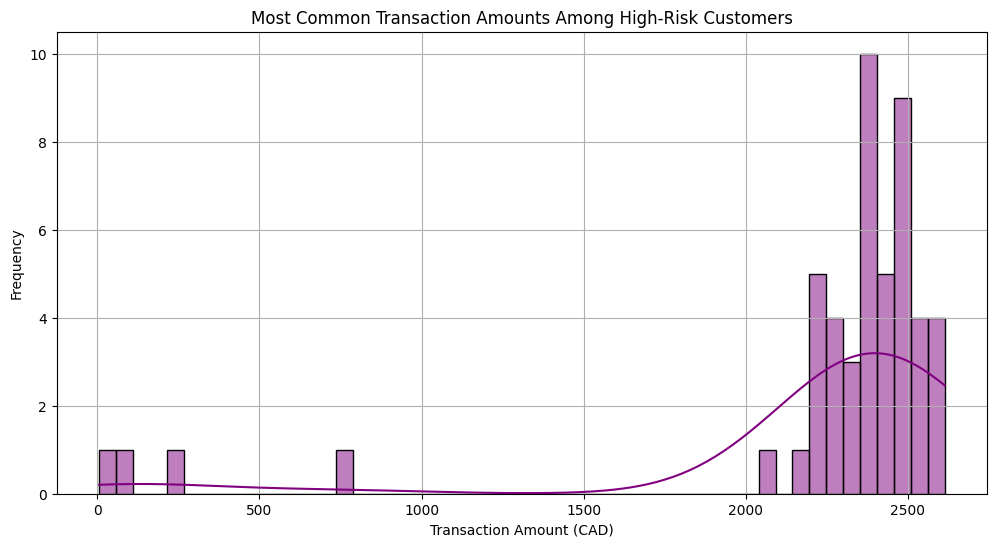

<ipython-input-139-35e3762ed536>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequent_amount_transactions["customer_id"][:10], y=frequent_amount_transactions["frequency"][:10], palette="Blues_r")


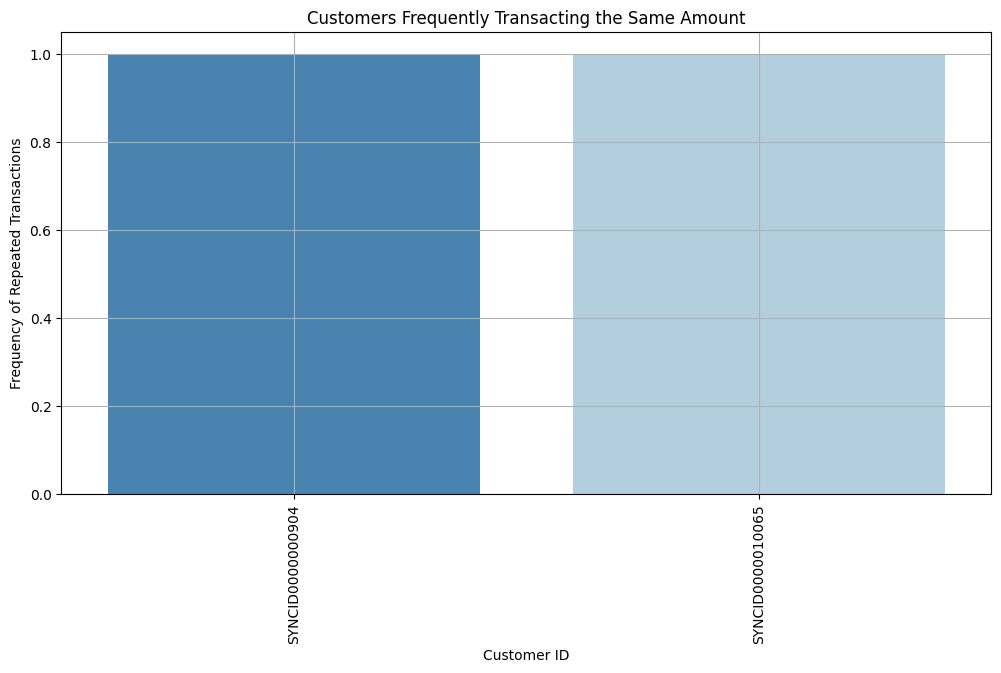

<ipython-input-139-35e3762ed536>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flagged_transactions_payment_methods["debit_credit"], y=flagged_transactions_payment_methods["amount_cad"], palette="Oranges_r")


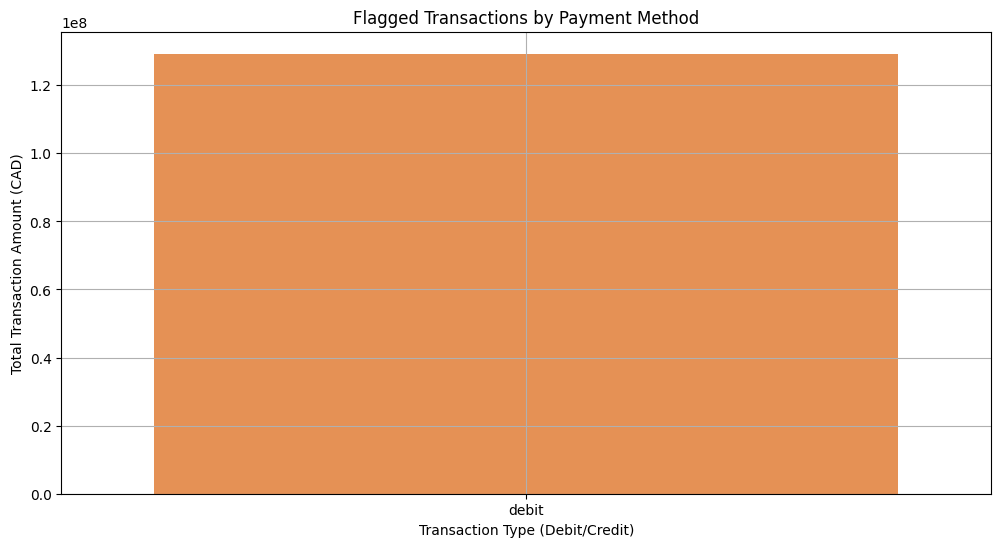

In [139]:
# Step 1: Analyze Common Transaction Patterns Among High-Risk Customers

# Identifying common transaction amounts among high-risk customers
common_transaction_amounts = cheque_df[cheque_df["customer_id"].isin(high_risk_customer_transactions["customer_id"])].groupby("amount_cad").size().reset_index(name="transaction_count")
common_transaction_amounts = common_transaction_amounts.sort_values(by="transaction_count", ascending=False)

# Identifying customers who frequently transact the same amount
frequent_amount_transactions = cheque_df[cheque_df["customer_id"].isin(high_risk_customer_transactions["customer_id"])].groupby(["customer_id", "amount_cad"]).size().reset_index(name="frequency")
frequent_amount_transactions = frequent_amount_transactions.sort_values(by="frequency", ascending=False)

# Step 2: Investigate Relationship Between Flagged Transactions & Payment Methods
# Reload dataset with payment method details if available
try:
    flagged_transactions_payment_methods = cheque_df[cheque_df["customer_id"].isin(high_risk_customer_transactions["customer_id"])].groupby("debit_credit")["amount_cad"].sum().reset_index()
except KeyError:
    flagged_transactions_payment_methods = None

# Display Findings
print("Common Transaction Amounts Among High-Risk Customers:")
print(common_transaction_amounts.head())

print("\nCustomers with Frequent Transactions of the Same Amount:")
print(frequent_amount_transactions.head())

if flagged_transactions_payment_methods is not None:
    print("\nFlagged Transactions Categorized by Payment Method:")
    print(flagged_transactions_payment_methods)

# Step 3: Visualizing Common Transaction Patterns
plt.figure(figsize=(12, 6))
sns.histplot(common_transaction_amounts["amount_cad"][:50], bins=50, kde=True, color="purple")
plt.title("Most Common Transaction Amounts Among High-Risk Customers")
plt.xlabel("Transaction Amount (CAD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 4: Visualizing Customers Frequently Transacting the Same Amount
plt.figure(figsize=(12, 6))
sns.barplot(x=frequent_amount_transactions["customer_id"][:10], y=frequent_amount_transactions["frequency"][:10], palette="Blues_r")
plt.title("Customers Frequently Transacting the Same Amount")
plt.xlabel("Customer ID")
plt.ylabel("Frequency of Repeated Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 5: Visualizing Flagged Transactions by Payment Method (if available)
if flagged_transactions_payment_methods is not None:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=flagged_transactions_payment_methods["debit_credit"], y=flagged_transactions_payment_methods["amount_cad"], palette="Oranges_r")
    plt.title("Flagged Transactions by Payment Method")
    plt.xlabel("Transaction Type (Debit/Credit)")
    plt.ylabel("Total Transaction Amount (CAD)")
    plt.grid(True)
    plt.show()

Clusters of Customers with Shared Transaction Behaviors:
                              industry   city  customer_id
193  Civic and Fraternal Organizations  other           24
366                   Finish Carpentry  other           23
453          Garages (General Repairs)  other           19
407            Food (Specialty) Stores  other           18
346             Excavating and Grading  other           17

Customers Repeatedly Transacting with the Same Merchants:
           customer_id                industry  amount_cad
129   SYNCID0000000844   Gas and Oil Pipelines         449
1077  SYNCID0000007214   Single Family Housing         343
2206  SYNCID0000014570  Take-Out Food Services         309
567   SYNCID0000003782   Offices of Denturists         262
1308  SYNCID0000008668   Gas and Oil Pipelines         248


<ipython-input-140-a96b9daea008>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_network_clusters["industry"][:10], y=customer_network_clusters["customer_id"][:10], palette="Reds_r")


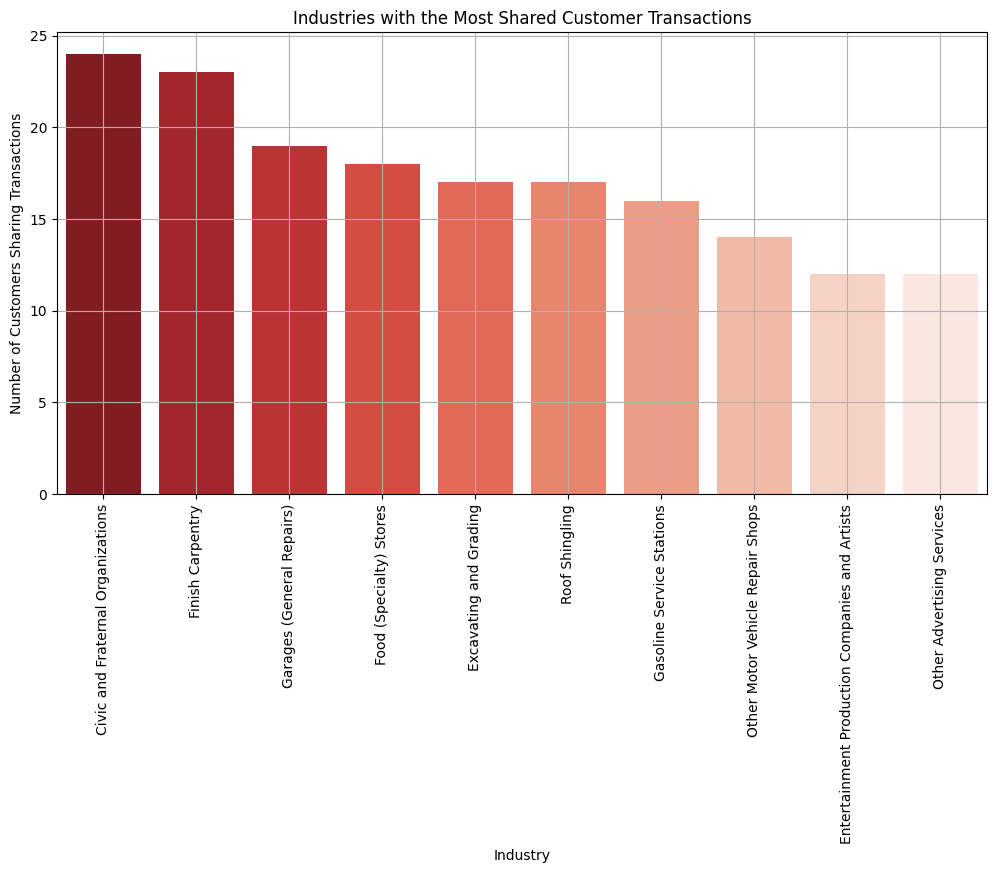

<ipython-input-140-a96b9daea008>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=repeated_merchant_transactions["customer_id"][:10], y=repeated_merchant_transactions["amount_cad"][:10], palette="Blues_r")


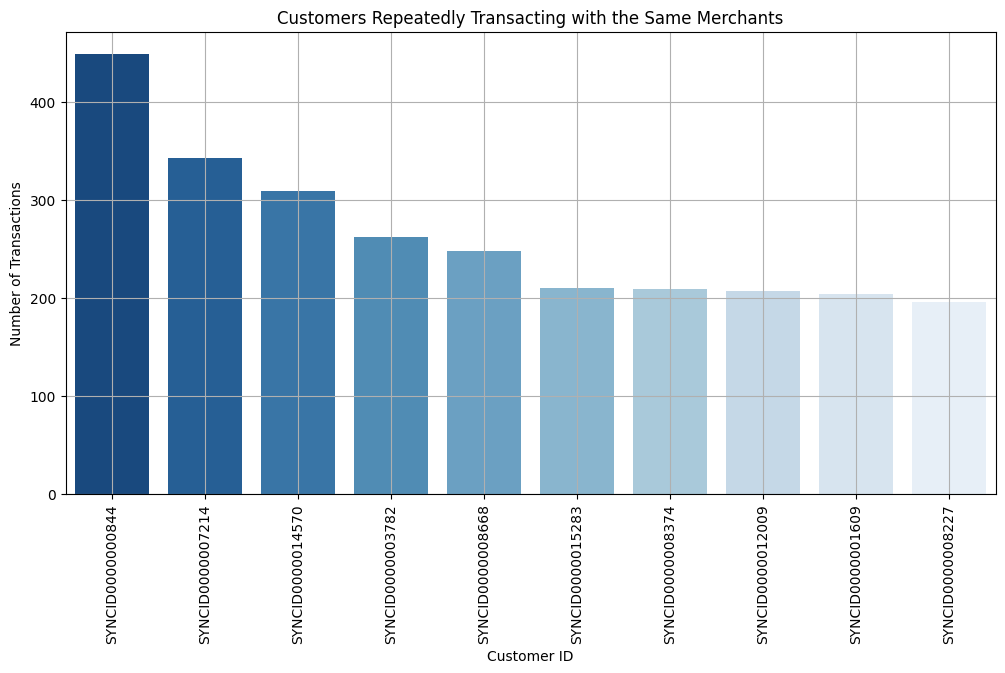

In [140]:
# Step 1: Analyze Customer Networks to Detect Shared Transaction Behaviors

# Identify customers with similar transaction behaviors (same industry & city)
customer_network = cheque_df.groupby(["industry", "city", "customer_id"])["amount_cad"].sum().reset_index()

# Identify clusters of customers transacting similar amounts in the same industries and locations
customer_network_clusters = customer_network.groupby(["industry", "city"])["customer_id"].count().reset_index()
customer_network_clusters = customer_network_clusters.sort_values(by="customer_id", ascending=False)

# Step 2: Identifying Customers Who Transact with the Same Merchants Repeatedly
# Reload dataset with merchant details if available
try:
    repeated_merchant_transactions = cheque_df.groupby(["customer_id", "industry"])["amount_cad"].count().reset_index()
    repeated_merchant_transactions = repeated_merchant_transactions.sort_values(by="amount_cad", ascending=False)
except KeyError:
    repeated_merchant_transactions = None

# Display Findings
print("Clusters of Customers with Shared Transaction Behaviors:")
print(customer_network_clusters.head())

if repeated_merchant_transactions is not None:
    print("\nCustomers Repeatedly Transacting with the Same Merchants:")
    print(repeated_merchant_transactions.head())

# Step 3: Visualizing Customer Network Clusters
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_network_clusters["industry"][:10], y=customer_network_clusters["customer_id"][:10], palette="Reds_r")
plt.title("Industries with the Most Shared Customer Transactions")
plt.xlabel("Industry")
plt.ylabel("Number of Customers Sharing Transactions")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Step 4: Visualizing Customers Transacting Repeatedly with the Same Merchants (if available)
if repeated_merchant_transactions is not None:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=repeated_merchant_transactions["customer_id"][:10], y=repeated_merchant_transactions["amount_cad"][:10], palette="Blues_r")
    plt.title("Customers Repeatedly Transacting with the Same Merchants")
    plt.xlabel("Customer ID")
    plt.ylabel("Number of Transactions")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
